# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

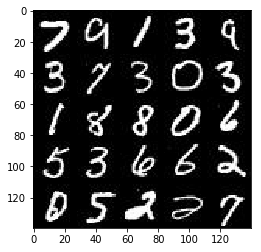

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

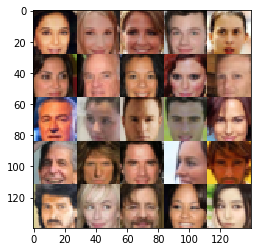

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
# my helper functions
def leaky_relu(tensor, alpha=0.2):
    return tf.maximum(alpha*tensor, tensor)

def array_product(array):
    """
    :param array: Array of tf.Dimension, need to be passed to int before calculation 
    """
    result = 1
    for n in array:
        result *= int(n)
    return result

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        layer = leaky_relu(layer)
        # 14x14x64 now
        
        layer = tf.layers.conv2d(layer, 256, 5, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(layer)
        # 7x7x128 now
        
        layer = tf.layers.conv2d(layer, 512, 5, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(layer)
        # 4x4x256 now
        
        layer = tf.reshape(layer, [-1, array_product(layer.get_shape()[1:])])
        logits = tf.layers.dense(layer, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*512)
        layer = tf.reshape(layer, [-1, 7, 7, 512])
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = leaky_relu(layer)
        # 7x7x256 now
        
        layer = tf.layers.conv2d_transpose(layer, 256, 5, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = leaky_relu(layer)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_size = data_shape[1:] # get width, height an channels 
    channels = image_size[-1]
    image_mode = 'L' if channels == 1 else 'RGB'
    
    input_real, input_z, learning_rate_placehoder = model_inputs(*image_size, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_placehoder: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_placehoder: learning_rate})
                
                # I added a print out to se how the loss is going
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, channels, image_mode)
                    
        show_generator_output(sess, 9, input_z, channels, image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 0.4723... Generator Loss: 6.7805
Epoch 1/10... Discriminator Loss: 0.0096... Generator Loss: 42.9658
Epoch 1/10... Discriminator Loss: 0.0722... Generator Loss: 12.3918
Epoch 1/10... Discriminator Loss: 1.5476... Generator Loss: 2.8623
Epoch 1/10... Discriminator Loss: 0.7465... Generator Loss: 2.4035
Epoch 1/10... Discriminator Loss: 1.0974... Generator Loss: 1.2463
Epoch 1/10... Discriminator Loss: 0.9752... Generator Loss: 5.6183
Epoch 1/10... Discriminator Loss: 0.3383... Generator Loss: 2.7583
Epoch 1/10... Discriminator Loss: 0.6247... Generator Loss: 1.3996
Epoch 1/10... Discriminator Loss: 1.9019... Generator Loss: 0.3309


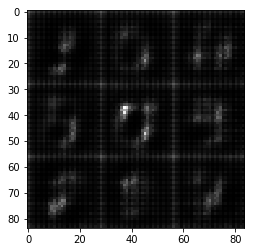

Epoch 1/10... Discriminator Loss: 0.3728... Generator Loss: 1.7173
Epoch 1/10... Discriminator Loss: 1.1400... Generator Loss: 0.4911
Epoch 1/10... Discriminator Loss: 0.3191... Generator Loss: 2.4954
Epoch 1/10... Discriminator Loss: 0.1320... Generator Loss: 2.9799
Epoch 1/10... Discriminator Loss: 0.1056... Generator Loss: 2.8859
Epoch 1/10... Discriminator Loss: 0.0809... Generator Loss: 3.3726
Epoch 1/10... Discriminator Loss: 0.0705... Generator Loss: 3.3946
Epoch 1/10... Discriminator Loss: 0.2992... Generator Loss: 1.5645
Epoch 1/10... Discriminator Loss: 0.7620... Generator Loss: 1.1435
Epoch 1/10... Discriminator Loss: 0.3495... Generator Loss: 2.0624


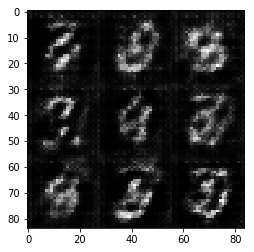

Epoch 1/10... Discriminator Loss: 0.1477... Generator Loss: 3.5200
Epoch 1/10... Discriminator Loss: 0.0267... Generator Loss: 4.3961
Epoch 1/10... Discriminator Loss: 0.0081... Generator Loss: 6.2998
Epoch 1/10... Discriminator Loss: 0.0269... Generator Loss: 4.4642
Epoch 1/10... Discriminator Loss: 0.3748... Generator Loss: 3.7962
Epoch 1/10... Discriminator Loss: 0.1992... Generator Loss: 2.3729
Epoch 1/10... Discriminator Loss: 0.1480... Generator Loss: 2.5862
Epoch 1/10... Discriminator Loss: 0.0872... Generator Loss: 4.7107
Epoch 1/10... Discriminator Loss: 0.0258... Generator Loss: 9.3705


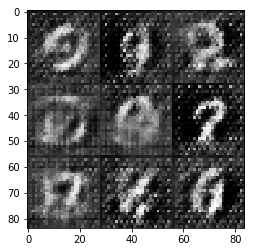

Epoch 1/10... Discriminator Loss: 0.0034... Generator Loss: 10.6337
Epoch 1/10... Discriminator Loss: 0.3856... Generator Loss: 5.2324
Epoch 1/10... Discriminator Loss: 0.7089... Generator Loss: 0.9982
Epoch 1/10... Discriminator Loss: 0.2575... Generator Loss: 2.0112
Epoch 1/10... Discriminator Loss: 0.0718... Generator Loss: 3.9730
Epoch 1/10... Discriminator Loss: 0.0165... Generator Loss: 5.4448
Epoch 1/10... Discriminator Loss: 0.3254... Generator Loss: 2.8026
Epoch 1/10... Discriminator Loss: 0.4697... Generator Loss: 1.9884
Epoch 1/10... Discriminator Loss: 0.0230... Generator Loss: 6.0411
Epoch 1/10... Discriminator Loss: 0.0289... Generator Loss: 4.9247


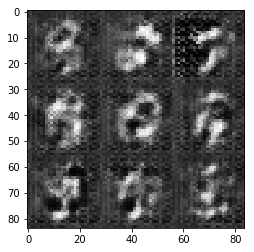

Epoch 1/10... Discriminator Loss: 0.0224... Generator Loss: 7.7490
Epoch 1/10... Discriminator Loss: 0.0084... Generator Loss: 6.3986
Epoch 1/10... Discriminator Loss: 0.0883... Generator Loss: 3.7488
Epoch 1/10... Discriminator Loss: 0.0096... Generator Loss: 7.5254
Epoch 1/10... Discriminator Loss: 2.0736... Generator Loss: 3.8018
Epoch 1/10... Discriminator Loss: 2.7215... Generator Loss: 0.1354
Epoch 2/10... Discriminator Loss: 0.4631... Generator Loss: 3.1757
Epoch 2/10... Discriminator Loss: 0.6500... Generator Loss: 2.6797
Epoch 2/10... Discriminator Loss: 0.5263... Generator Loss: 4.4243
Epoch 2/10... Discriminator Loss: 0.0666... Generator Loss: 4.0720


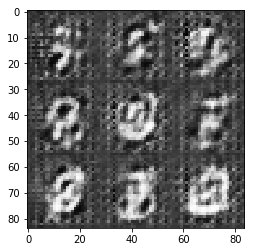

Epoch 2/10... Discriminator Loss: 0.0473... Generator Loss: 6.3538
Epoch 2/10... Discriminator Loss: 0.0879... Generator Loss: 3.6469
Epoch 2/10... Discriminator Loss: 0.1200... Generator Loss: 2.8331
Epoch 2/10... Discriminator Loss: 0.0503... Generator Loss: 4.2022
Epoch 2/10... Discriminator Loss: 2.4571... Generator Loss: 5.9199
Epoch 2/10... Discriminator Loss: 0.6019... Generator Loss: 2.7229
Epoch 2/10... Discriminator Loss: 1.5451... Generator Loss: 7.2828
Epoch 2/10... Discriminator Loss: 2.3315... Generator Loss: 4.5670
Epoch 2/10... Discriminator Loss: 0.7566... Generator Loss: 1.0322
Epoch 2/10... Discriminator Loss: 0.8409... Generator Loss: 4.6331


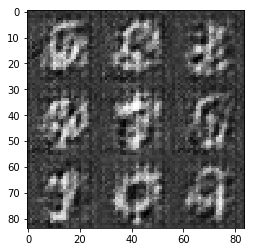

Epoch 2/10... Discriminator Loss: 0.3700... Generator Loss: 1.7173
Epoch 2/10... Discriminator Loss: 0.1640... Generator Loss: 2.8537
Epoch 2/10... Discriminator Loss: 0.7574... Generator Loss: 0.7955
Epoch 2/10... Discriminator Loss: 0.0874... Generator Loss: 4.7633
Epoch 2/10... Discriminator Loss: 0.0137... Generator Loss: 12.1391
Epoch 2/10... Discriminator Loss: 0.0187... Generator Loss: 4.6549
Epoch 2/10... Discriminator Loss: 0.0035... Generator Loss: 10.1142
Epoch 2/10... Discriminator Loss: 0.0168... Generator Loss: 5.8875
Epoch 2/10... Discriminator Loss: 0.5489... Generator Loss: 1.1351
Epoch 2/10... Discriminator Loss: 0.0046... Generator Loss: 10.2717


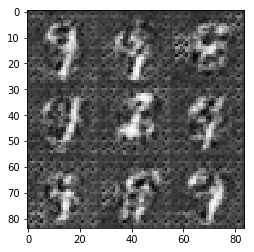

Epoch 2/10... Discriminator Loss: 0.0254... Generator Loss: 8.3861
Epoch 2/10... Discriminator Loss: 1.5167... Generator Loss: 0.3588
Epoch 2/10... Discriminator Loss: 2.4390... Generator Loss: 5.1473
Epoch 2/10... Discriminator Loss: 0.9585... Generator Loss: 3.0022
Epoch 2/10... Discriminator Loss: 0.5062... Generator Loss: 1.3081
Epoch 2/10... Discriminator Loss: 0.4974... Generator Loss: 1.2950
Epoch 2/10... Discriminator Loss: 0.1334... Generator Loss: 2.8696
Epoch 2/10... Discriminator Loss: 0.4662... Generator Loss: 1.2259
Epoch 2/10... Discriminator Loss: 0.1932... Generator Loss: 2.3368
Epoch 2/10... Discriminator Loss: 0.0887... Generator Loss: 3.0891


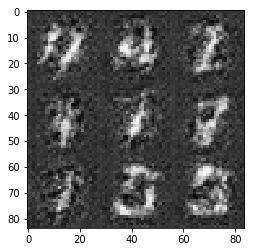

Epoch 2/10... Discriminator Loss: 0.0723... Generator Loss: 3.3318
Epoch 2/10... Discriminator Loss: 0.0270... Generator Loss: 4.8947
Epoch 2/10... Discriminator Loss: 1.5673... Generator Loss: 7.1944
Epoch 2/10... Discriminator Loss: 3.7037... Generator Loss: 3.3178
Epoch 2/10... Discriminator Loss: 0.8601... Generator Loss: 1.6368
Epoch 2/10... Discriminator Loss: 0.7435... Generator Loss: 0.9728
Epoch 2/10... Discriminator Loss: 1.0596... Generator Loss: 1.0293
Epoch 2/10... Discriminator Loss: 1.9818... Generator Loss: 2.2234
Epoch 2/10... Discriminator Loss: 0.8216... Generator Loss: 1.2606
Epoch 2/10... Discriminator Loss: 1.1677... Generator Loss: 0.5730


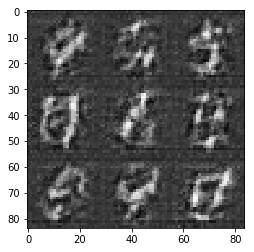

Epoch 2/10... Discriminator Loss: 0.8848... Generator Loss: 0.8225
Epoch 2/10... Discriminator Loss: 0.6516... Generator Loss: 1.4530
Epoch 2/10... Discriminator Loss: 0.7326... Generator Loss: 0.8988
Epoch 3/10... Discriminator Loss: 0.4191... Generator Loss: 1.7285
Epoch 3/10... Discriminator Loss: 0.6184... Generator Loss: 0.9558
Epoch 3/10... Discriminator Loss: 0.3509... Generator Loss: 2.4207
Epoch 3/10... Discriminator Loss: 0.3076... Generator Loss: 1.8900
Epoch 3/10... Discriminator Loss: 1.2358... Generator Loss: 5.3021
Epoch 3/10... Discriminator Loss: 0.2275... Generator Loss: 2.4219
Epoch 3/10... Discriminator Loss: 0.4809... Generator Loss: 4.3776


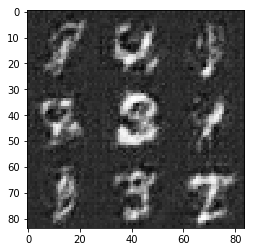

Epoch 3/10... Discriminator Loss: 0.5305... Generator Loss: 4.1412
Epoch 3/10... Discriminator Loss: 0.1614... Generator Loss: 3.1969
Epoch 3/10... Discriminator Loss: 0.1865... Generator Loss: 2.6618
Epoch 3/10... Discriminator Loss: 0.5522... Generator Loss: 1.3625
Epoch 3/10... Discriminator Loss: 0.2755... Generator Loss: 2.2451
Epoch 3/10... Discriminator Loss: 0.2981... Generator Loss: 1.7857
Epoch 3/10... Discriminator Loss: 0.1768... Generator Loss: 2.4590
Epoch 3/10... Discriminator Loss: 0.1711... Generator Loss: 2.4463
Epoch 3/10... Discriminator Loss: 0.0807... Generator Loss: 3.1001
Epoch 3/10... Discriminator Loss: 0.0332... Generator Loss: 4.4400


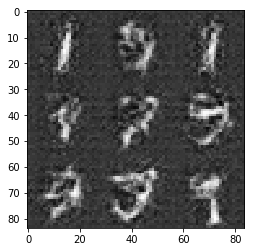

Epoch 3/10... Discriminator Loss: 0.0499... Generator Loss: 3.7399
Epoch 3/10... Discriminator Loss: 0.0693... Generator Loss: 3.2473
Epoch 3/10... Discriminator Loss: 0.0523... Generator Loss: 3.4695
Epoch 3/10... Discriminator Loss: 0.0175... Generator Loss: 5.5746
Epoch 3/10... Discriminator Loss: 0.0113... Generator Loss: 5.3973
Epoch 3/10... Discriminator Loss: 0.0392... Generator Loss: 3.8947
Epoch 3/10... Discriminator Loss: 0.0592... Generator Loss: 3.3416
Epoch 3/10... Discriminator Loss: 0.0140... Generator Loss: 5.2655
Epoch 3/10... Discriminator Loss: 0.0238... Generator Loss: 4.5872
Epoch 3/10... Discriminator Loss: 0.0982... Generator Loss: 2.9300


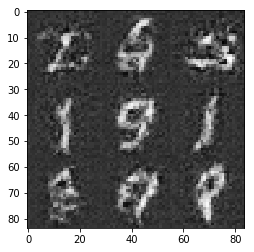

Epoch 3/10... Discriminator Loss: 0.0068... Generator Loss: 6.4414
Epoch 3/10... Discriminator Loss: 0.0103... Generator Loss: 5.7977
Epoch 3/10... Discriminator Loss: 0.0202... Generator Loss: 4.4549
Epoch 3/10... Discriminator Loss: 0.0480... Generator Loss: 3.5630
Epoch 3/10... Discriminator Loss: 0.0125... Generator Loss: 5.2947
Epoch 3/10... Discriminator Loss: 0.0053... Generator Loss: 6.8241
Epoch 3/10... Discriminator Loss: 0.0191... Generator Loss: 4.4312
Epoch 3/10... Discriminator Loss: 0.0320... Generator Loss: 4.0374
Epoch 3/10... Discriminator Loss: 0.0162... Generator Loss: 4.7587
Epoch 3/10... Discriminator Loss: 0.0081... Generator Loss: 5.5584


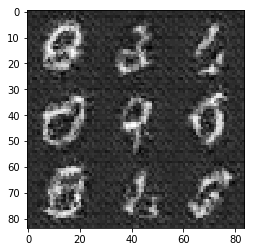

Epoch 3/10... Discriminator Loss: 0.0056... Generator Loss: 9.4120
Epoch 3/10... Discriminator Loss: 0.0237... Generator Loss: 10.3720
Epoch 3/10... Discriminator Loss: 0.0179... Generator Loss: 4.5543
Epoch 3/10... Discriminator Loss: 2.5305... Generator Loss: 0.2466
Epoch 3/10... Discriminator Loss: 0.9284... Generator Loss: 0.8833
Epoch 3/10... Discriminator Loss: 0.8090... Generator Loss: 1.1251
Epoch 3/10... Discriminator Loss: 0.9974... Generator Loss: 1.6325
Epoch 3/10... Discriminator Loss: 0.7715... Generator Loss: 1.2775
Epoch 3/10... Discriminator Loss: 0.7675... Generator Loss: 0.8957
Epoch 3/10... Discriminator Loss: 0.4088... Generator Loss: 2.1944


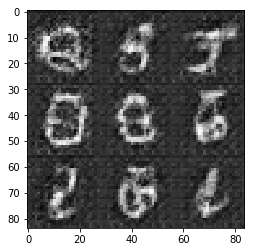

Epoch 4/10... Discriminator Loss: 0.3261... Generator Loss: 2.4522
Epoch 4/10... Discriminator Loss: 0.4663... Generator Loss: 1.2853
Epoch 4/10... Discriminator Loss: 0.5159... Generator Loss: 1.1391
Epoch 4/10... Discriminator Loss: 0.5165... Generator Loss: 1.1768
Epoch 4/10... Discriminator Loss: 0.1552... Generator Loss: 2.5112
Epoch 4/10... Discriminator Loss: 0.3779... Generator Loss: 1.4380
Epoch 4/10... Discriminator Loss: 0.3403... Generator Loss: 1.5543
Epoch 4/10... Discriminator Loss: 0.0525... Generator Loss: 3.4930
Epoch 4/10... Discriminator Loss: 0.1601... Generator Loss: 2.3426
Epoch 4/10... Discriminator Loss: 0.0403... Generator Loss: 4.0940


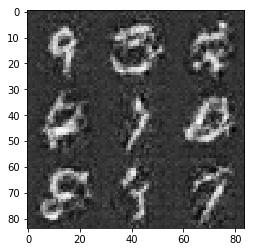

Epoch 4/10... Discriminator Loss: 0.0507... Generator Loss: 3.6318
Epoch 4/10... Discriminator Loss: 0.0671... Generator Loss: 3.3299
Epoch 4/10... Discriminator Loss: 0.1430... Generator Loss: 2.3709
Epoch 4/10... Discriminator Loss: 0.1036... Generator Loss: 2.7441
Epoch 4/10... Discriminator Loss: 0.0182... Generator Loss: 5.9499
Epoch 4/10... Discriminator Loss: 0.0129... Generator Loss: 6.2726
Epoch 4/10... Discriminator Loss: 0.0757... Generator Loss: 3.0069
Epoch 4/10... Discriminator Loss: 0.0113... Generator Loss: 6.4149
Epoch 4/10... Discriminator Loss: 0.0471... Generator Loss: 3.6657
Epoch 4/10... Discriminator Loss: 0.0073... Generator Loss: 6.1654


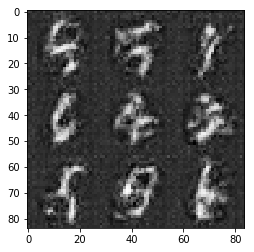

Epoch 4/10... Discriminator Loss: 0.0190... Generator Loss: 4.6954
Epoch 4/10... Discriminator Loss: 0.0517... Generator Loss: 3.3926
Epoch 4/10... Discriminator Loss: 0.0160... Generator Loss: 5.1608
Epoch 4/10... Discriminator Loss: 0.0045... Generator Loss: 9.0680
Epoch 4/10... Discriminator Loss: 0.0393... Generator Loss: 3.8275
Epoch 4/10... Discriminator Loss: 0.0161... Generator Loss: 4.6514
Epoch 4/10... Discriminator Loss: 0.0036... Generator Loss: 7.7975
Epoch 4/10... Discriminator Loss: 0.0855... Generator Loss: 2.8963
Epoch 4/10... Discriminator Loss: 0.0053... Generator Loss: 7.2946
Epoch 4/10... Discriminator Loss: 0.0031... Generator Loss: 7.6060


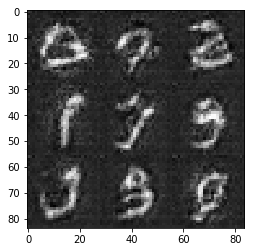

Epoch 4/10... Discriminator Loss: 0.0134... Generator Loss: 4.7065
Epoch 4/10... Discriminator Loss: 0.0083... Generator Loss: 5.8581
Epoch 4/10... Discriminator Loss: 0.0970... Generator Loss: 2.7008
Epoch 4/10... Discriminator Loss: 0.0081... Generator Loss: 6.0439
Epoch 4/10... Discriminator Loss: 1.4282... Generator Loss: 1.8636
Epoch 4/10... Discriminator Loss: 0.9952... Generator Loss: 0.7304
Epoch 4/10... Discriminator Loss: 0.9115... Generator Loss: 0.7223
Epoch 4/10... Discriminator Loss: 0.8417... Generator Loss: 0.8391
Epoch 4/10... Discriminator Loss: 0.5561... Generator Loss: 2.5883
Epoch 4/10... Discriminator Loss: 0.4542... Generator Loss: 1.3163


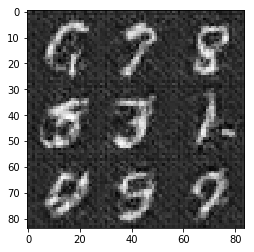

Epoch 4/10... Discriminator Loss: 0.4395... Generator Loss: 1.6140
Epoch 4/10... Discriminator Loss: 0.6862... Generator Loss: 0.9041
Epoch 4/10... Discriminator Loss: 0.2880... Generator Loss: 1.8225
Epoch 4/10... Discriminator Loss: 0.2315... Generator Loss: 2.1389
Epoch 4/10... Discriminator Loss: 0.1692... Generator Loss: 3.6351
Epoch 4/10... Discriminator Loss: 0.5625... Generator Loss: 1.0280
Epoch 4/10... Discriminator Loss: 0.2624... Generator Loss: 2.0280
Epoch 5/10... Discriminator Loss: 0.3723... Generator Loss: 1.5019
Epoch 5/10... Discriminator Loss: 0.2414... Generator Loss: 2.0451
Epoch 5/10... Discriminator Loss: 0.0764... Generator Loss: 3.2824


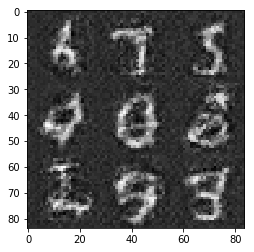

Epoch 5/10... Discriminator Loss: 0.2099... Generator Loss: 2.2051
Epoch 5/10... Discriminator Loss: 0.0621... Generator Loss: 3.1853
Epoch 5/10... Discriminator Loss: 0.0717... Generator Loss: 3.0829
Epoch 5/10... Discriminator Loss: 0.0520... Generator Loss: 3.6707
Epoch 5/10... Discriminator Loss: 0.0393... Generator Loss: 3.7666
Epoch 5/10... Discriminator Loss: 0.1412... Generator Loss: 2.3769
Epoch 5/10... Discriminator Loss: 0.0269... Generator Loss: 4.5157
Epoch 5/10... Discriminator Loss: 0.0311... Generator Loss: 4.2412
Epoch 5/10... Discriminator Loss: 0.0148... Generator Loss: 4.9081
Epoch 5/10... Discriminator Loss: 0.0129... Generator Loss: 5.4188


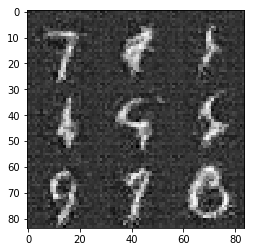

Epoch 5/10... Discriminator Loss: 0.0175... Generator Loss: 5.0026
Epoch 5/10... Discriminator Loss: 0.0115... Generator Loss: 5.8871
Epoch 5/10... Discriminator Loss: 0.0658... Generator Loss: 3.1815
Epoch 5/10... Discriminator Loss: 0.0169... Generator Loss: 4.7773
Epoch 5/10... Discriminator Loss: 0.0120... Generator Loss: 5.0110
Epoch 5/10... Discriminator Loss: 0.0118... Generator Loss: 5.1001
Epoch 5/10... Discriminator Loss: 0.0189... Generator Loss: 5.7252
Epoch 5/10... Discriminator Loss: 0.1587... Generator Loss: 2.2158
Epoch 5/10... Discriminator Loss: 3.9121... Generator Loss: 0.0965
Epoch 5/10... Discriminator Loss: 0.8562... Generator Loss: 1.2727


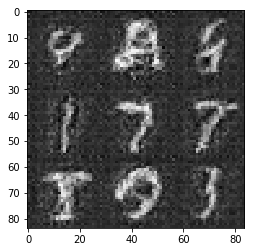

Epoch 5/10... Discriminator Loss: 0.7257... Generator Loss: 1.1475
Epoch 5/10... Discriminator Loss: 0.7705... Generator Loss: 1.7703
Epoch 5/10... Discriminator Loss: 0.6592... Generator Loss: 1.1362
Epoch 5/10... Discriminator Loss: 0.7013... Generator Loss: 2.1301
Epoch 5/10... Discriminator Loss: 0.8482... Generator Loss: 2.8166
Epoch 5/10... Discriminator Loss: 1.2190... Generator Loss: 3.8142
Epoch 5/10... Discriminator Loss: 0.7606... Generator Loss: 3.0781
Epoch 5/10... Discriminator Loss: 0.8058... Generator Loss: 2.8695
Epoch 5/10... Discriminator Loss: 0.4603... Generator Loss: 1.8637
Epoch 5/10... Discriminator Loss: 1.4651... Generator Loss: 4.6082


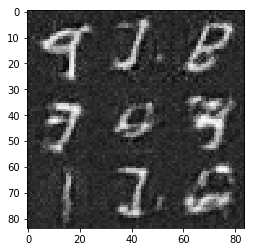

Epoch 5/10... Discriminator Loss: 0.7235... Generator Loss: 0.9066
Epoch 5/10... Discriminator Loss: 0.4878... Generator Loss: 2.7726
Epoch 5/10... Discriminator Loss: 0.5727... Generator Loss: 2.3402
Epoch 5/10... Discriminator Loss: 0.7554... Generator Loss: 0.8122
Epoch 5/10... Discriminator Loss: 0.3390... Generator Loss: 1.7486
Epoch 5/10... Discriminator Loss: 2.7628... Generator Loss: 0.1010
Epoch 5/10... Discriminator Loss: 0.3434... Generator Loss: 1.8876
Epoch 5/10... Discriminator Loss: 0.2518... Generator Loss: 2.1209
Epoch 5/10... Discriminator Loss: 0.4072... Generator Loss: 1.3930
Epoch 5/10... Discriminator Loss: 0.1962... Generator Loss: 2.2785


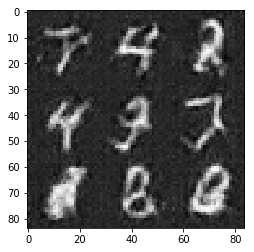

Epoch 5/10... Discriminator Loss: 0.3064... Generator Loss: 1.5996
Epoch 5/10... Discriminator Loss: 0.4491... Generator Loss: 4.0581
Epoch 5/10... Discriminator Loss: 0.2366... Generator Loss: 2.0082
Epoch 5/10... Discriminator Loss: 0.1508... Generator Loss: 2.5185
Epoch 6/10... Discriminator Loss: 0.1025... Generator Loss: 2.9590
Epoch 6/10... Discriminator Loss: 0.0771... Generator Loss: 3.7089
Epoch 6/10... Discriminator Loss: 0.0499... Generator Loss: 3.8946
Epoch 6/10... Discriminator Loss: 0.0554... Generator Loss: 4.9969
Epoch 6/10... Discriminator Loss: 0.0450... Generator Loss: 4.0347
Epoch 6/10... Discriminator Loss: 0.1302... Generator Loss: 4.2803


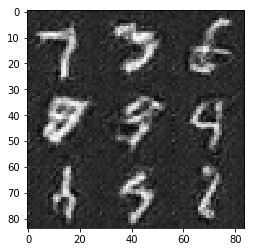

Epoch 6/10... Discriminator Loss: 0.1376... Generator Loss: 2.4955
Epoch 6/10... Discriminator Loss: 1.2718... Generator Loss: 0.5897
Epoch 6/10... Discriminator Loss: 0.3679... Generator Loss: 1.7998
Epoch 6/10... Discriminator Loss: 0.2550... Generator Loss: 2.3195
Epoch 6/10... Discriminator Loss: 0.2046... Generator Loss: 2.5902
Epoch 6/10... Discriminator Loss: 0.1790... Generator Loss: 2.5596
Epoch 6/10... Discriminator Loss: 0.1544... Generator Loss: 2.5991
Epoch 6/10... Discriminator Loss: 0.1617... Generator Loss: 2.3591
Epoch 6/10... Discriminator Loss: 0.0981... Generator Loss: 2.9775
Epoch 6/10... Discriminator Loss: 0.0861... Generator Loss: 2.9189


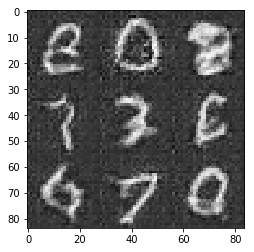

Epoch 6/10... Discriminator Loss: 0.0379... Generator Loss: 4.0300
Epoch 6/10... Discriminator Loss: 0.0119... Generator Loss: 5.6932
Epoch 6/10... Discriminator Loss: 0.0252... Generator Loss: 4.4514
Epoch 6/10... Discriminator Loss: 0.0134... Generator Loss: 5.3309
Epoch 6/10... Discriminator Loss: 0.0687... Generator Loss: 3.1725
Epoch 6/10... Discriminator Loss: 0.0195... Generator Loss: 4.5844
Epoch 6/10... Discriminator Loss: 0.0117... Generator Loss: 6.9067
Epoch 6/10... Discriminator Loss: 0.0098... Generator Loss: 5.2433
Epoch 6/10... Discriminator Loss: 0.0143... Generator Loss: 5.0232
Epoch 6/10... Discriminator Loss: 0.0068... Generator Loss: 5.8923


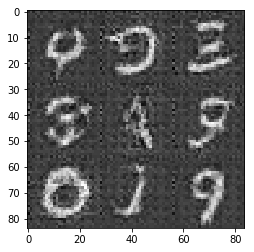

Epoch 6/10... Discriminator Loss: 0.0049... Generator Loss: 6.1858
Epoch 6/10... Discriminator Loss: 0.0059... Generator Loss: 6.1944
Epoch 6/10... Discriminator Loss: 0.0078... Generator Loss: 5.6995
Epoch 6/10... Discriminator Loss: 0.0115... Generator Loss: 5.2107
Epoch 6/10... Discriminator Loss: 0.0072... Generator Loss: 5.7563
Epoch 6/10... Discriminator Loss: 0.0072... Generator Loss: 5.5929
Epoch 6/10... Discriminator Loss: 0.0341... Generator Loss: 3.8200
Epoch 6/10... Discriminator Loss: 0.0396... Generator Loss: 3.8263
Epoch 6/10... Discriminator Loss: 0.0097... Generator Loss: 5.6309
Epoch 6/10... Discriminator Loss: 0.0098... Generator Loss: 5.3496


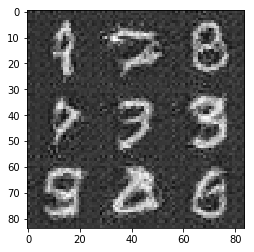

Epoch 6/10... Discriminator Loss: 0.0090... Generator Loss: 5.3431
Epoch 6/10... Discriminator Loss: 0.0144... Generator Loss: 4.9233
Epoch 6/10... Discriminator Loss: 0.0101... Generator Loss: 10.5543
Epoch 6/10... Discriminator Loss: 0.0043... Generator Loss: 6.9264
Epoch 6/10... Discriminator Loss: 0.0015... Generator Loss: 8.0821
Epoch 6/10... Discriminator Loss: 0.0042... Generator Loss: 6.3923
Epoch 6/10... Discriminator Loss: 0.0027... Generator Loss: 8.4622
Epoch 6/10... Discriminator Loss: 0.0604... Generator Loss: 3.2787
Epoch 6/10... Discriminator Loss: 0.0042... Generator Loss: 6.8308
Epoch 6/10... Discriminator Loss: 0.0016... Generator Loss: 9.1427


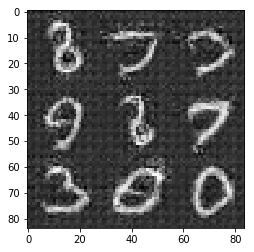

Epoch 7/10... Discriminator Loss: 0.0044... Generator Loss: 6.9885
Epoch 7/10... Discriminator Loss: 0.0037... Generator Loss: 6.6168
Epoch 7/10... Discriminator Loss: 0.0071... Generator Loss: 7.4844
Epoch 7/10... Discriminator Loss: 0.0142... Generator Loss: 4.7430
Epoch 7/10... Discriminator Loss: 0.0087... Generator Loss: 5.3094
Epoch 7/10... Discriminator Loss: 0.0031... Generator Loss: 8.0326
Epoch 7/10... Discriminator Loss: 0.0029... Generator Loss: 6.9243
Epoch 7/10... Discriminator Loss: 0.0297... Generator Loss: 4.2048
Epoch 7/10... Discriminator Loss: 1.7831... Generator Loss: 3.2989
Epoch 7/10... Discriminator Loss: 1.0419... Generator Loss: 0.9509


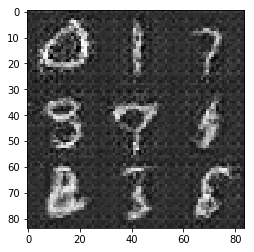

Epoch 7/10... Discriminator Loss: 0.6053... Generator Loss: 1.3468
Epoch 7/10... Discriminator Loss: 0.6952... Generator Loss: 1.3258
Epoch 7/10... Discriminator Loss: 1.2451... Generator Loss: 2.7177
Epoch 7/10... Discriminator Loss: 0.7891... Generator Loss: 0.9726
Epoch 7/10... Discriminator Loss: 0.6778... Generator Loss: 3.0583
Epoch 7/10... Discriminator Loss: 1.1278... Generator Loss: 4.2416
Epoch 7/10... Discriminator Loss: 0.6133... Generator Loss: 1.1296
Epoch 7/10... Discriminator Loss: 0.3630... Generator Loss: 2.1756
Epoch 7/10... Discriminator Loss: 0.4104... Generator Loss: 2.5684
Epoch 7/10... Discriminator Loss: 1.4187... Generator Loss: 5.4474


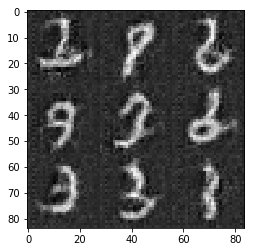

Epoch 7/10... Discriminator Loss: 0.5142... Generator Loss: 1.7534
Epoch 7/10... Discriminator Loss: 0.3188... Generator Loss: 2.7604
Epoch 7/10... Discriminator Loss: 1.1218... Generator Loss: 5.3234
Epoch 7/10... Discriminator Loss: 0.5381... Generator Loss: 1.1959
Epoch 7/10... Discriminator Loss: 0.2923... Generator Loss: 1.9584
Epoch 7/10... Discriminator Loss: 0.1966... Generator Loss: 2.3179
Epoch 7/10... Discriminator Loss: 0.2520... Generator Loss: 2.0351
Epoch 7/10... Discriminator Loss: 0.1092... Generator Loss: 3.1972
Epoch 7/10... Discriminator Loss: 0.0848... Generator Loss: 3.1728
Epoch 7/10... Discriminator Loss: 0.1137... Generator Loss: 2.8472


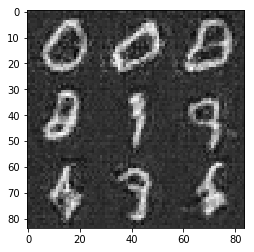

Epoch 7/10... Discriminator Loss: 0.1030... Generator Loss: 2.8294
Epoch 7/10... Discriminator Loss: 0.2271... Generator Loss: 1.9920
Epoch 7/10... Discriminator Loss: 0.1325... Generator Loss: 2.6172
Epoch 7/10... Discriminator Loss: 0.0331... Generator Loss: 4.4510
Epoch 7/10... Discriminator Loss: 0.0268... Generator Loss: 4.2188
Epoch 7/10... Discriminator Loss: 0.1815... Generator Loss: 2.1827
Epoch 7/10... Discriminator Loss: 0.0449... Generator Loss: 3.6605
Epoch 7/10... Discriminator Loss: 0.0228... Generator Loss: 4.4787
Epoch 7/10... Discriminator Loss: 0.0111... Generator Loss: 5.3432
Epoch 7/10... Discriminator Loss: 0.0708... Generator Loss: 3.2713


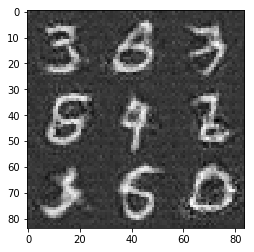

Epoch 7/10... Discriminator Loss: 0.0484... Generator Loss: 3.6638
Epoch 7/10... Discriminator Loss: 0.0206... Generator Loss: 4.7146
Epoch 7/10... Discriminator Loss: 0.0422... Generator Loss: 3.8216
Epoch 7/10... Discriminator Loss: 0.0122... Generator Loss: 5.3495
Epoch 7/10... Discriminator Loss: 0.0168... Generator Loss: 5.5472
Epoch 7/10... Discriminator Loss: 0.5933... Generator Loss: 1.4217
Epoch 7/10... Discriminator Loss: 1.8805... Generator Loss: 0.3648
Epoch 8/10... Discriminator Loss: 0.6067... Generator Loss: 1.0984
Epoch 8/10... Discriminator Loss: 0.1989... Generator Loss: 2.3885
Epoch 8/10... Discriminator Loss: 0.2140... Generator Loss: 2.0876


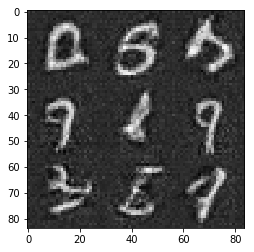

Epoch 8/10... Discriminator Loss: 0.1642... Generator Loss: 2.5128
Epoch 8/10... Discriminator Loss: 0.0629... Generator Loss: 3.8246
Epoch 8/10... Discriminator Loss: 0.1376... Generator Loss: 2.6405
Epoch 8/10... Discriminator Loss: 0.0319... Generator Loss: 4.4698
Epoch 8/10... Discriminator Loss: 0.0965... Generator Loss: 2.9789
Epoch 8/10... Discriminator Loss: 0.0095... Generator Loss: 6.1388
Epoch 8/10... Discriminator Loss: 0.0199... Generator Loss: 4.5833
Epoch 8/10... Discriminator Loss: 0.0242... Generator Loss: 4.7781
Epoch 8/10... Discriminator Loss: 0.0612... Generator Loss: 3.5119
Epoch 8/10... Discriminator Loss: 0.0102... Generator Loss: 5.6475


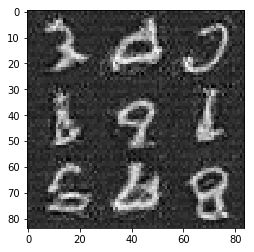

Epoch 8/10... Discriminator Loss: 0.0183... Generator Loss: 4.8990
Epoch 8/10... Discriminator Loss: 0.0198... Generator Loss: 4.7223
Epoch 8/10... Discriminator Loss: 0.0286... Generator Loss: 4.3884
Epoch 8/10... Discriminator Loss: 0.0371... Generator Loss: 4.0793
Epoch 8/10... Discriminator Loss: 0.0019... Generator Loss: 8.0233
Epoch 8/10... Discriminator Loss: 0.0355... Generator Loss: 4.0745
Epoch 8/10... Discriminator Loss: 0.0292... Generator Loss: 4.3250
Epoch 8/10... Discriminator Loss: 0.0066... Generator Loss: 6.8540
Epoch 8/10... Discriminator Loss: 5.6714... Generator Loss: 0.0909
Epoch 8/10... Discriminator Loss: 1.8739... Generator Loss: 0.2832


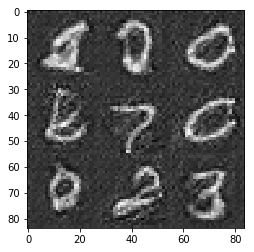

Epoch 8/10... Discriminator Loss: 1.4086... Generator Loss: 0.4419
Epoch 8/10... Discriminator Loss: 1.2466... Generator Loss: 0.4627
Epoch 8/10... Discriminator Loss: 1.3385... Generator Loss: 0.4563
Epoch 8/10... Discriminator Loss: 1.2186... Generator Loss: 0.4611
Epoch 8/10... Discriminator Loss: 1.2767... Generator Loss: 0.4466
Epoch 8/10... Discriminator Loss: 1.6417... Generator Loss: 0.3482
Epoch 8/10... Discriminator Loss: 0.9173... Generator Loss: 0.8148
Epoch 8/10... Discriminator Loss: 1.4988... Generator Loss: 0.3487
Epoch 8/10... Discriminator Loss: 1.4221... Generator Loss: 0.3839
Epoch 8/10... Discriminator Loss: 0.8638... Generator Loss: 1.1735


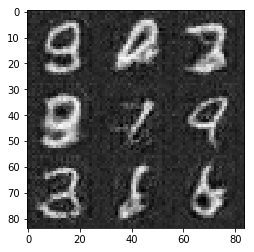

Epoch 8/10... Discriminator Loss: 1.1303... Generator Loss: 2.2779
Epoch 8/10... Discriminator Loss: 1.5179... Generator Loss: 2.9327
Epoch 8/10... Discriminator Loss: 1.5193... Generator Loss: 3.3808
Epoch 8/10... Discriminator Loss: 0.7104... Generator Loss: 1.5965
Epoch 8/10... Discriminator Loss: 1.6243... Generator Loss: 3.8151
Epoch 8/10... Discriminator Loss: 1.2887... Generator Loss: 3.6899
Epoch 8/10... Discriminator Loss: 0.8530... Generator Loss: 0.7869
Epoch 8/10... Discriminator Loss: 0.5032... Generator Loss: 2.0556
Epoch 8/10... Discriminator Loss: 0.4670... Generator Loss: 1.5393
Epoch 8/10... Discriminator Loss: 0.9952... Generator Loss: 0.7822


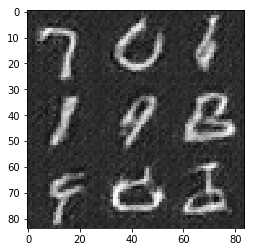

Epoch 8/10... Discriminator Loss: 1.2470... Generator Loss: 0.5150
Epoch 8/10... Discriminator Loss: 0.3303... Generator Loss: 2.4767
Epoch 8/10... Discriminator Loss: 0.3475... Generator Loss: 1.6010
Epoch 8/10... Discriminator Loss: 0.4408... Generator Loss: 1.6862
Epoch 9/10... Discriminator Loss: 0.2905... Generator Loss: 1.7675
Epoch 9/10... Discriminator Loss: 0.2787... Generator Loss: 1.7632
Epoch 9/10... Discriminator Loss: 0.0853... Generator Loss: 2.9745
Epoch 9/10... Discriminator Loss: 0.0694... Generator Loss: 3.3352
Epoch 9/10... Discriminator Loss: 0.1578... Generator Loss: 2.3697
Epoch 9/10... Discriminator Loss: 0.0810... Generator Loss: 3.1302


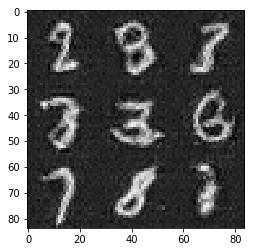

Epoch 9/10... Discriminator Loss: 0.0130... Generator Loss: 5.6963
Epoch 9/10... Discriminator Loss: 0.0332... Generator Loss: 4.8493
Epoch 9/10... Discriminator Loss: 0.0288... Generator Loss: 4.2935
Epoch 9/10... Discriminator Loss: 0.0313... Generator Loss: 4.0399
Epoch 9/10... Discriminator Loss: 0.0171... Generator Loss: 5.0797
Epoch 9/10... Discriminator Loss: 0.0435... Generator Loss: 3.5851
Epoch 9/10... Discriminator Loss: 0.0090... Generator Loss: 5.5309
Epoch 9/10... Discriminator Loss: 0.0489... Generator Loss: 3.5393
Epoch 9/10... Discriminator Loss: 0.0279... Generator Loss: 4.1930
Epoch 9/10... Discriminator Loss: 0.0124... Generator Loss: 5.2887


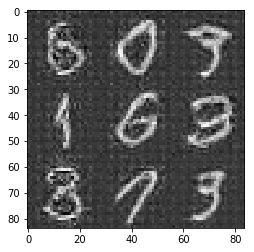

Epoch 9/10... Discriminator Loss: 0.0028... Generator Loss: 8.1455
Epoch 9/10... Discriminator Loss: 0.0067... Generator Loss: 7.7114
Epoch 9/10... Discriminator Loss: 0.0336... Generator Loss: 3.9554
Epoch 9/10... Discriminator Loss: 0.0184... Generator Loss: 4.6098
Epoch 9/10... Discriminator Loss: 0.0144... Generator Loss: 5.2501
Epoch 9/10... Discriminator Loss: 0.0362... Generator Loss: 3.6838
Epoch 9/10... Discriminator Loss: 0.0174... Generator Loss: 5.3331
Epoch 9/10... Discriminator Loss: 0.0257... Generator Loss: 4.1066
Epoch 9/10... Discriminator Loss: 0.0042... Generator Loss: 7.1033
Epoch 9/10... Discriminator Loss: 0.0032... Generator Loss: 7.8473


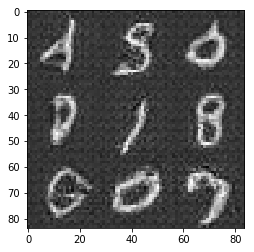

Epoch 9/10... Discriminator Loss: 0.0056... Generator Loss: 5.9640
Epoch 9/10... Discriminator Loss: 0.0029... Generator Loss: 8.0718
Epoch 9/10... Discriminator Loss: 0.0446... Generator Loss: 3.6354
Epoch 9/10... Discriminator Loss: 0.0042... Generator Loss: 7.3196
Epoch 9/10... Discriminator Loss: 0.0032... Generator Loss: 6.4148
Epoch 9/10... Discriminator Loss: 0.0456... Generator Loss: 3.6609
Epoch 9/10... Discriminator Loss: 0.0014... Generator Loss: 9.4296
Epoch 9/10... Discriminator Loss: 0.0148... Generator Loss: 5.0603
Epoch 9/10... Discriminator Loss: 0.0195... Generator Loss: 4.5633
Epoch 9/10... Discriminator Loss: 0.0037... Generator Loss: 6.5624


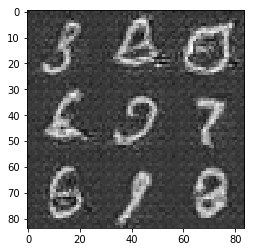

Epoch 9/10... Discriminator Loss: 0.0025... Generator Loss: 6.9191
Epoch 9/10... Discriminator Loss: 0.0043... Generator Loss: 7.5963
Epoch 9/10... Discriminator Loss: 0.0093... Generator Loss: 5.2276
Epoch 9/10... Discriminator Loss: 0.0029... Generator Loss: 7.4731
Epoch 9/10... Discriminator Loss: 0.0064... Generator Loss: 5.8240
Epoch 9/10... Discriminator Loss: 0.0027... Generator Loss: 7.2123
Epoch 9/10... Discriminator Loss: 0.0038... Generator Loss: 6.9111
Epoch 9/10... Discriminator Loss: 0.0050... Generator Loss: 6.0326
Epoch 9/10... Discriminator Loss: 0.0198... Generator Loss: 4.3260
Epoch 9/10... Discriminator Loss: 0.0027... Generator Loss: 7.6135


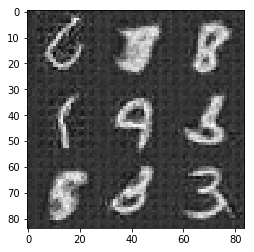

Epoch 9/10... Discriminator Loss: 0.0046... Generator Loss: 6.1144
Epoch 10/10... Discriminator Loss: 0.0015... Generator Loss: 7.7120
Epoch 10/10... Discriminator Loss: 0.0118... Generator Loss: 5.0738
Epoch 10/10... Discriminator Loss: 0.0028... Generator Loss: 8.7827
Epoch 10/10... Discriminator Loss: 0.0226... Generator Loss: 4.5440
Epoch 10/10... Discriminator Loss: 0.0014... Generator Loss: 7.4220
Epoch 10/10... Discriminator Loss: 0.0025... Generator Loss: 7.4483
Epoch 10/10... Discriminator Loss: 0.0021... Generator Loss: 9.7050
Epoch 10/10... Discriminator Loss: 0.1979... Generator Loss: 6.8653
Epoch 10/10... Discriminator Loss: 1.1766... Generator Loss: 0.6119


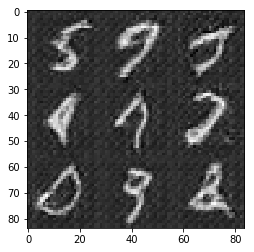

Epoch 10/10... Discriminator Loss: 0.5202... Generator Loss: 3.9953
Epoch 10/10... Discriminator Loss: 0.5215... Generator Loss: 1.3356
Epoch 10/10... Discriminator Loss: 0.2485... Generator Loss: 2.7856
Epoch 10/10... Discriminator Loss: 0.1759... Generator Loss: 3.0472
Epoch 10/10... Discriminator Loss: 0.1173... Generator Loss: 3.0857
Epoch 10/10... Discriminator Loss: 2.8939... Generator Loss: 0.1602
Epoch 10/10... Discriminator Loss: 0.2663... Generator Loss: 2.6301
Epoch 10/10... Discriminator Loss: 0.2088... Generator Loss: 2.2406
Epoch 10/10... Discriminator Loss: 0.3285... Generator Loss: 4.6697
Epoch 10/10... Discriminator Loss: 0.1440... Generator Loss: 2.6093


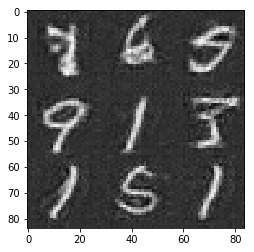

Epoch 10/10... Discriminator Loss: 0.1228... Generator Loss: 2.8019
Epoch 10/10... Discriminator Loss: 0.5689... Generator Loss: 2.3159
Epoch 10/10... Discriminator Loss: 0.3661... Generator Loss: 2.0294
Epoch 10/10... Discriminator Loss: 0.2614... Generator Loss: 2.3097
Epoch 10/10... Discriminator Loss: 0.2547... Generator Loss: 3.1384
Epoch 10/10... Discriminator Loss: 0.1459... Generator Loss: 2.9192
Epoch 10/10... Discriminator Loss: 0.1940... Generator Loss: 2.2000
Epoch 10/10... Discriminator Loss: 0.0741... Generator Loss: 3.2901
Epoch 10/10... Discriminator Loss: 0.0719... Generator Loss: 3.5276
Epoch 10/10... Discriminator Loss: 0.0605... Generator Loss: 3.5110


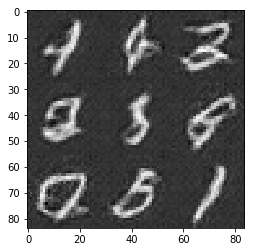

Epoch 10/10... Discriminator Loss: 0.0549... Generator Loss: 5.0020
Epoch 10/10... Discriminator Loss: 0.0090... Generator Loss: 7.7689
Epoch 10/10... Discriminator Loss: 0.0412... Generator Loss: 4.0345
Epoch 10/10... Discriminator Loss: 0.0273... Generator Loss: 4.2336
Epoch 10/10... Discriminator Loss: 0.0115... Generator Loss: 6.1073
Epoch 10/10... Discriminator Loss: 0.0315... Generator Loss: 4.2079
Epoch 10/10... Discriminator Loss: 0.0253... Generator Loss: 4.4296
Epoch 10/10... Discriminator Loss: 0.0151... Generator Loss: 5.0897
Epoch 10/10... Discriminator Loss: 0.0136... Generator Loss: 5.1600
Epoch 10/10... Discriminator Loss: 0.0335... Generator Loss: 4.1313


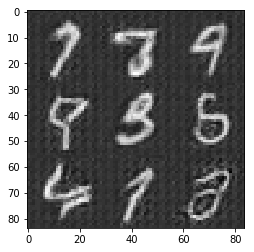

Epoch 10/10... Discriminator Loss: 0.0236... Generator Loss: 4.5253
Epoch 10/10... Discriminator Loss: 0.0313... Generator Loss: 4.0803
Epoch 10/10... Discriminator Loss: 0.0120... Generator Loss: 5.3885
Epoch 10/10... Discriminator Loss: 3.5155... Generator Loss: 0.1325
Epoch 10/10... Discriminator Loss: 1.3709... Generator Loss: 0.4572
Epoch 10/10... Discriminator Loss: 0.9217... Generator Loss: 1.7565
Epoch 10/10... Discriminator Loss: 1.4289... Generator Loss: 0.4451
Epoch 10/10... Discriminator Loss: 1.2605... Generator Loss: 2.7576


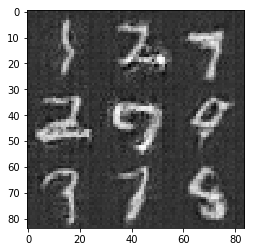

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 13.4243... Generator Loss: 0.0000
Epoch 1/10... Discriminator Loss: 6.6348... Generator Loss: 0.0124
Epoch 1/10... Discriminator Loss: 8.5088... Generator Loss: 0.5930
Epoch 1/10... Discriminator Loss: 0.3664... Generator Loss: 31.4390
Epoch 1/10... Discriminator Loss: 1.2350... Generator Loss: 2.5814
Epoch 1/10... Discriminator Loss: 1.8711... Generator Loss: 0.5354
Epoch 1/10... Discriminator Loss: 0.3307... Generator Loss: 3.6665
Epoch 1/10... Discriminator Loss: 0.1534... Generator Loss: 4.9141
Epoch 1/10... Discriminator Loss: 0.4181... Generator Loss: 1.7046
Epoch 1/10... Discriminator Loss: 3.7955... Generator Loss: 16.4175


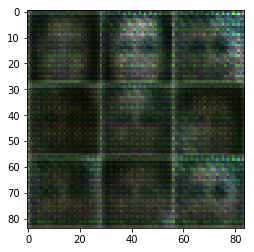

Epoch 1/10... Discriminator Loss: 0.2574... Generator Loss: 2.0737
Epoch 1/10... Discriminator Loss: 0.0136... Generator Loss: 8.6028
Epoch 1/10... Discriminator Loss: 0.0400... Generator Loss: 4.1280
Epoch 1/10... Discriminator Loss: 0.0191... Generator Loss: 5.1852
Epoch 1/10... Discriminator Loss: 0.0074... Generator Loss: 10.1913
Epoch 1/10... Discriminator Loss: 0.0070... Generator Loss: 8.4900
Epoch 1/10... Discriminator Loss: 2.3328... Generator Loss: 3.3451
Epoch 1/10... Discriminator Loss: 3.1232... Generator Loss: 7.0413
Epoch 1/10... Discriminator Loss: 0.3066... Generator Loss: 2.6170
Epoch 1/10... Discriminator Loss: 0.0733... Generator Loss: 3.6807


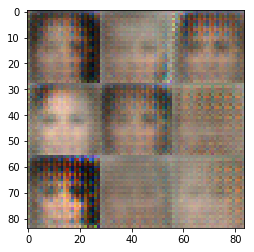

Epoch 1/10... Discriminator Loss: 0.0611... Generator Loss: 7.5432
Epoch 1/10... Discriminator Loss: 0.0085... Generator Loss: 13.0075
Epoch 1/10... Discriminator Loss: 0.0590... Generator Loss: 4.0617
Epoch 1/10... Discriminator Loss: 0.0588... Generator Loss: 3.4983
Epoch 1/10... Discriminator Loss: 0.0468... Generator Loss: 9.5560
Epoch 1/10... Discriminator Loss: 0.1644... Generator Loss: 8.9760
Epoch 1/10... Discriminator Loss: 3.0869... Generator Loss: 0.3636
Epoch 1/10... Discriminator Loss: 0.6650... Generator Loss: 1.2244
Epoch 1/10... Discriminator Loss: 0.9366... Generator Loss: 0.8525
Epoch 1/10... Discriminator Loss: 0.2982... Generator Loss: 2.1504


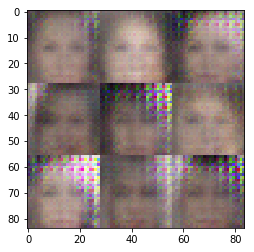

Epoch 1/10... Discriminator Loss: 0.2927... Generator Loss: 3.9222
Epoch 1/10... Discriminator Loss: 0.5157... Generator Loss: 2.7951
Epoch 1/10... Discriminator Loss: 0.2217... Generator Loss: 1.8812
Epoch 1/10... Discriminator Loss: 0.0211... Generator Loss: 6.0340
Epoch 1/10... Discriminator Loss: 0.2646... Generator Loss: 2.0839
Epoch 1/10... Discriminator Loss: 0.0099... Generator Loss: 9.5537
Epoch 1/10... Discriminator Loss: 0.0176... Generator Loss: 14.3673
Epoch 1/10... Discriminator Loss: 0.0370... Generator Loss: 5.5118
Epoch 1/10... Discriminator Loss: 0.0287... Generator Loss: 4.5267
Epoch 1/10... Discriminator Loss: 0.0038... Generator Loss: 7.8711


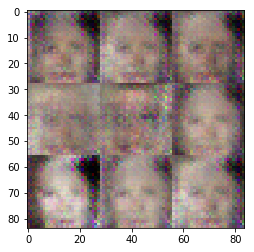

Epoch 1/10... Discriminator Loss: 0.1050... Generator Loss: 3.0199
Epoch 1/10... Discriminator Loss: 0.0494... Generator Loss: 5.4530
Epoch 1/10... Discriminator Loss: 0.0287... Generator Loss: 4.3785
Epoch 1/10... Discriminator Loss: 5.0044... Generator Loss: 0.0396
Epoch 1/10... Discriminator Loss: 1.3064... Generator Loss: 0.6417
Epoch 1/10... Discriminator Loss: 0.9573... Generator Loss: 1.0229
Epoch 1/10... Discriminator Loss: 1.6850... Generator Loss: 0.2824
Epoch 1/10... Discriminator Loss: 1.9227... Generator Loss: 2.3643
Epoch 1/10... Discriminator Loss: 1.3297... Generator Loss: 0.6403
Epoch 1/10... Discriminator Loss: 1.3260... Generator Loss: 0.9528


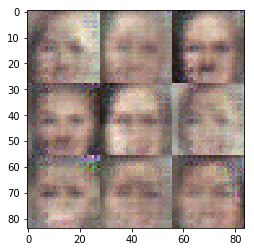

Epoch 1/10... Discriminator Loss: 1.2712... Generator Loss: 0.6760
Epoch 1/10... Discriminator Loss: 1.4761... Generator Loss: 2.1824
Epoch 1/10... Discriminator Loss: 1.0103... Generator Loss: 1.7982
Epoch 1/10... Discriminator Loss: 0.8501... Generator Loss: 1.2246
Epoch 1/10... Discriminator Loss: 0.5686... Generator Loss: 4.7129
Epoch 1/10... Discriminator Loss: 1.1980... Generator Loss: 1.5082
Epoch 1/10... Discriminator Loss: 0.9214... Generator Loss: 1.5292
Epoch 1/10... Discriminator Loss: 0.3604... Generator Loss: 2.0317
Epoch 1/10... Discriminator Loss: 2.0039... Generator Loss: 0.2775
Epoch 1/10... Discriminator Loss: 1.8828... Generator Loss: 4.2098


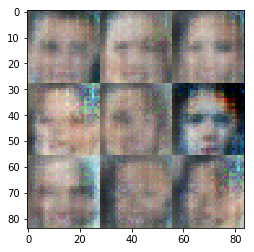

Epoch 1/10... Discriminator Loss: 0.1937... Generator Loss: 4.0447
Epoch 1/10... Discriminator Loss: 1.1074... Generator Loss: 0.7335
Epoch 1/10... Discriminator Loss: 0.2470... Generator Loss: 5.0715
Epoch 1/10... Discriminator Loss: 0.1697... Generator Loss: 3.5808
Epoch 1/10... Discriminator Loss: 1.1545... Generator Loss: 4.8229
Epoch 1/10... Discriminator Loss: 0.5761... Generator Loss: 1.1755
Epoch 1/10... Discriminator Loss: 0.3640... Generator Loss: 4.8067
Epoch 1/10... Discriminator Loss: 0.0369... Generator Loss: 4.1964
Epoch 1/10... Discriminator Loss: 0.0451... Generator Loss: 10.3212
Epoch 1/10... Discriminator Loss: 0.0568... Generator Loss: 6.9333


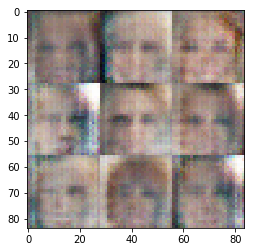

Epoch 1/10... Discriminator Loss: 0.0014... Generator Loss: 10.9859
Epoch 1/10... Discriminator Loss: 0.0118... Generator Loss: 6.3897
Epoch 1/10... Discriminator Loss: 0.0115... Generator Loss: 10.8608
Epoch 1/10... Discriminator Loss: 0.0123... Generator Loss: 8.3863
Epoch 1/10... Discriminator Loss: 0.0128... Generator Loss: 5.0322
Epoch 1/10... Discriminator Loss: 0.0049... Generator Loss: 6.3048
Epoch 1/10... Discriminator Loss: 1.1160... Generator Loss: 0.6818
Epoch 1/10... Discriminator Loss: 0.5199... Generator Loss: 1.0870
Epoch 1/10... Discriminator Loss: 0.0149... Generator Loss: 6.9706
Epoch 1/10... Discriminator Loss: 0.0066... Generator Loss: 6.9164


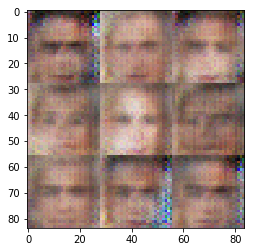

Epoch 1/10... Discriminator Loss: 0.0374... Generator Loss: 6.5770
Epoch 1/10... Discriminator Loss: 0.0001... Generator Loss: 11.8624
Epoch 1/10... Discriminator Loss: 0.0099... Generator Loss: 8.1969
Epoch 1/10... Discriminator Loss: 0.0022... Generator Loss: 9.0143
Epoch 1/10... Discriminator Loss: 0.0092... Generator Loss: 5.4526
Epoch 1/10... Discriminator Loss: 0.0013... Generator Loss: 8.5669
Epoch 1/10... Discriminator Loss: 0.0022... Generator Loss: 10.7220
Epoch 1/10... Discriminator Loss: 0.0016... Generator Loss: 8.7957
Epoch 1/10... Discriminator Loss: 0.0028... Generator Loss: 6.7211
Epoch 1/10... Discriminator Loss: 0.0024... Generator Loss: 10.0358


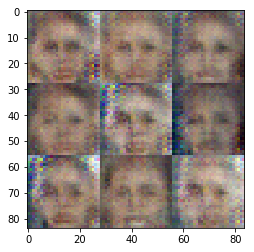

Epoch 1/10... Discriminator Loss: 0.0122... Generator Loss: 7.5458
Epoch 1/10... Discriminator Loss: 2.1502... Generator Loss: 0.6933
Epoch 1/10... Discriminator Loss: 0.6938... Generator Loss: 1.3211
Epoch 1/10... Discriminator Loss: 0.1901... Generator Loss: 2.2847
Epoch 1/10... Discriminator Loss: 0.1781... Generator Loss: 2.4293
Epoch 1/10... Discriminator Loss: 0.7034... Generator Loss: 3.4942
Epoch 1/10... Discriminator Loss: 2.3972... Generator Loss: 0.3238
Epoch 1/10... Discriminator Loss: 1.0180... Generator Loss: 1.1024
Epoch 1/10... Discriminator Loss: 1.0823... Generator Loss: 1.4249
Epoch 1/10... Discriminator Loss: 1.1454... Generator Loss: 1.6919


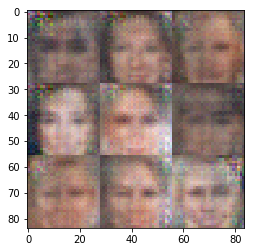

Epoch 1/10... Discriminator Loss: 1.0802... Generator Loss: 0.5664
Epoch 1/10... Discriminator Loss: 0.7145... Generator Loss: 1.0583
Epoch 1/10... Discriminator Loss: 1.3322... Generator Loss: 1.7726
Epoch 1/10... Discriminator Loss: 0.5362... Generator Loss: 1.4028
Epoch 1/10... Discriminator Loss: 0.0941... Generator Loss: 4.6466
Epoch 1/10... Discriminator Loss: 0.0410... Generator Loss: 6.4229
Epoch 1/10... Discriminator Loss: 0.0105... Generator Loss: 5.2631
Epoch 1/10... Discriminator Loss: 0.0078... Generator Loss: 7.5190
Epoch 1/10... Discriminator Loss: 0.0090... Generator Loss: 5.9167
Epoch 1/10... Discriminator Loss: 0.0110... Generator Loss: 5.8254


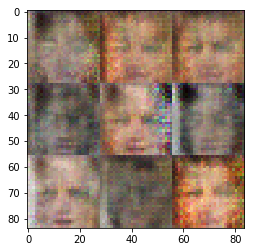

Epoch 1/10... Discriminator Loss: 0.3040... Generator Loss: 6.2321
Epoch 1/10... Discriminator Loss: 0.0094... Generator Loss: 5.9474
Epoch 1/10... Discriminator Loss: 0.0115... Generator Loss: 5.4463
Epoch 1/10... Discriminator Loss: 0.2295... Generator Loss: 2.0534
Epoch 1/10... Discriminator Loss: 0.7785... Generator Loss: 1.3191
Epoch 1/10... Discriminator Loss: 0.4590... Generator Loss: 1.8341
Epoch 1/10... Discriminator Loss: 2.9369... Generator Loss: 4.4567
Epoch 1/10... Discriminator Loss: 0.7426... Generator Loss: 5.4462
Epoch 1/10... Discriminator Loss: 0.0214... Generator Loss: 6.8534
Epoch 1/10... Discriminator Loss: 0.0579... Generator Loss: 3.5233


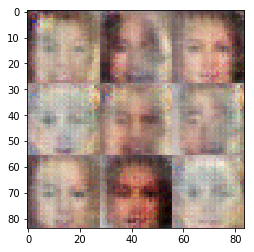

Epoch 1/10... Discriminator Loss: 0.0993... Generator Loss: 2.6267
Epoch 1/10... Discriminator Loss: 0.0195... Generator Loss: 4.8707
Epoch 1/10... Discriminator Loss: 0.0127... Generator Loss: 5.2352
Epoch 1/10... Discriminator Loss: 0.0680... Generator Loss: 2.9257
Epoch 1/10... Discriminator Loss: 0.0288... Generator Loss: 3.8533
Epoch 1/10... Discriminator Loss: 0.0156... Generator Loss: 5.3480
Epoch 1/10... Discriminator Loss: 0.0117... Generator Loss: 5.4646
Epoch 1/10... Discriminator Loss: 0.0096... Generator Loss: 8.5743
Epoch 1/10... Discriminator Loss: 0.0042... Generator Loss: 7.0344
Epoch 1/10... Discriminator Loss: 0.0031... Generator Loss: 9.5918


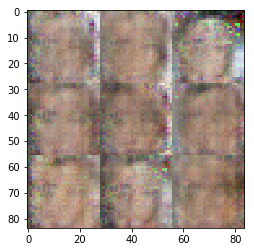

Epoch 1/10... Discriminator Loss: 0.0024... Generator Loss: 8.0406
Epoch 1/10... Discriminator Loss: 2.1755... Generator Loss: 0.6758
Epoch 1/10... Discriminator Loss: 0.7132... Generator Loss: 1.1956
Epoch 1/10... Discriminator Loss: 0.3941... Generator Loss: 1.6777
Epoch 1/10... Discriminator Loss: 0.0853... Generator Loss: 2.8602
Epoch 1/10... Discriminator Loss: 2.2276... Generator Loss: 0.5150
Epoch 1/10... Discriminator Loss: 1.0351... Generator Loss: 0.8009
Epoch 1/10... Discriminator Loss: 1.0184... Generator Loss: 0.9224
Epoch 1/10... Discriminator Loss: 1.1417... Generator Loss: 0.6803
Epoch 1/10... Discriminator Loss: 0.7816... Generator Loss: 1.0715


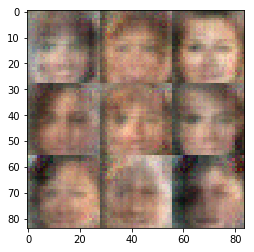

Epoch 1/10... Discriminator Loss: 1.8561... Generator Loss: 0.3292
Epoch 1/10... Discriminator Loss: 0.2753... Generator Loss: 2.0626
Epoch 1/10... Discriminator Loss: 0.1129... Generator Loss: 3.2831
Epoch 1/10... Discriminator Loss: 1.1043... Generator Loss: 3.4350
Epoch 1/10... Discriminator Loss: 0.6259... Generator Loss: 1.1567
Epoch 1/10... Discriminator Loss: 0.0376... Generator Loss: 6.6408
Epoch 1/10... Discriminator Loss: 2.2692... Generator Loss: 1.9596
Epoch 1/10... Discriminator Loss: 0.7000... Generator Loss: 1.4011
Epoch 1/10... Discriminator Loss: 1.3482... Generator Loss: 2.4968
Epoch 1/10... Discriminator Loss: 1.3257... Generator Loss: 0.5473


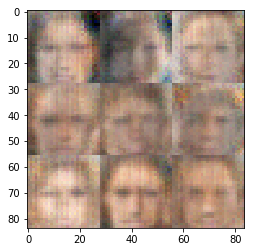

Epoch 1/10... Discriminator Loss: 0.5959... Generator Loss: 1.6372
Epoch 1/10... Discriminator Loss: 1.0801... Generator Loss: 0.6141
Epoch 1/10... Discriminator Loss: 0.7792... Generator Loss: 1.0416
Epoch 1/10... Discriminator Loss: 0.0139... Generator Loss: 6.1156
Epoch 1/10... Discriminator Loss: 0.0134... Generator Loss: 7.6123
Epoch 1/10... Discriminator Loss: 0.0060... Generator Loss: 7.2729
Epoch 1/10... Discriminator Loss: 0.0464... Generator Loss: 11.2265
Epoch 1/10... Discriminator Loss: 0.0018... Generator Loss: 8.9069
Epoch 2/10... Discriminator Loss: 0.0283... Generator Loss: 4.5814
Epoch 2/10... Discriminator Loss: 0.0142... Generator Loss: 5.6203


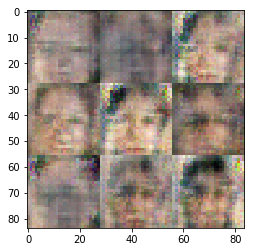

Epoch 2/10... Discriminator Loss: 0.0046... Generator Loss: 7.2611
Epoch 2/10... Discriminator Loss: 0.0108... Generator Loss: 6.6792
Epoch 2/10... Discriminator Loss: 0.0013... Generator Loss: 11.4928
Epoch 2/10... Discriminator Loss: 0.0096... Generator Loss: 6.2403
Epoch 2/10... Discriminator Loss: 0.0032... Generator Loss: 7.9398
Epoch 2/10... Discriminator Loss: 1.2474... Generator Loss: 8.1700
Epoch 2/10... Discriminator Loss: 0.0911... Generator Loss: 3.0031
Epoch 2/10... Discriminator Loss: 0.0105... Generator Loss: 6.2050
Epoch 2/10... Discriminator Loss: 0.0128... Generator Loss: 5.7104
Epoch 2/10... Discriminator Loss: 0.0273... Generator Loss: 4.0244


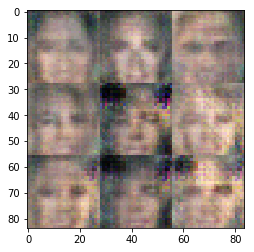

Epoch 2/10... Discriminator Loss: 0.1985... Generator Loss: 6.6154
Epoch 2/10... Discriminator Loss: 0.0159... Generator Loss: 5.5740
Epoch 2/10... Discriminator Loss: 0.0060... Generator Loss: 8.4901
Epoch 2/10... Discriminator Loss: 0.2412... Generator Loss: 2.0599
Epoch 2/10... Discriminator Loss: 0.2643... Generator Loss: 2.3041
Epoch 2/10... Discriminator Loss: 0.0066... Generator Loss: 11.4673
Epoch 2/10... Discriminator Loss: 0.0072... Generator Loss: 7.6992
Epoch 2/10... Discriminator Loss: 0.0029... Generator Loss: 7.2774
Epoch 2/10... Discriminator Loss: 0.0147... Generator Loss: 5.1858
Epoch 2/10... Discriminator Loss: 0.0097... Generator Loss: 6.0032


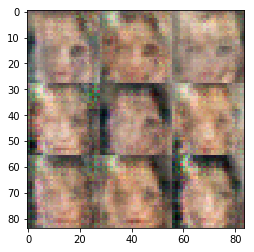

Epoch 2/10... Discriminator Loss: 0.3622... Generator Loss: 8.8072
Epoch 2/10... Discriminator Loss: 0.0035... Generator Loss: 7.4965
Epoch 2/10... Discriminator Loss: 0.0016... Generator Loss: 8.0434
Epoch 2/10... Discriminator Loss: 0.1511... Generator Loss: 2.3689
Epoch 2/10... Discriminator Loss: 1.4732... Generator Loss: 0.5472
Epoch 2/10... Discriminator Loss: 0.9060... Generator Loss: 0.8765
Epoch 2/10... Discriminator Loss: 0.7701... Generator Loss: 1.4649
Epoch 2/10... Discriminator Loss: 1.5136... Generator Loss: 2.3178
Epoch 2/10... Discriminator Loss: 1.6807... Generator Loss: 2.9303
Epoch 2/10... Discriminator Loss: 1.0312... Generator Loss: 1.1505


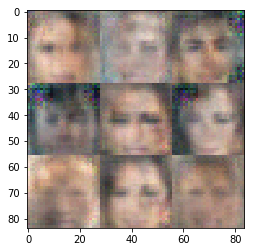

Epoch 2/10... Discriminator Loss: 1.0267... Generator Loss: 2.1690
Epoch 2/10... Discriminator Loss: 1.5282... Generator Loss: 1.3253
Epoch 2/10... Discriminator Loss: 1.2518... Generator Loss: 0.6693
Epoch 2/10... Discriminator Loss: 1.0078... Generator Loss: 0.9737
Epoch 2/10... Discriminator Loss: 1.2148... Generator Loss: 0.8982
Epoch 2/10... Discriminator Loss: 1.2140... Generator Loss: 0.6378
Epoch 2/10... Discriminator Loss: 1.8278... Generator Loss: 0.3358
Epoch 2/10... Discriminator Loss: 0.3675... Generator Loss: 3.0641
Epoch 2/10... Discriminator Loss: 0.0755... Generator Loss: 3.8500
Epoch 2/10... Discriminator Loss: 0.3223... Generator Loss: 1.7679


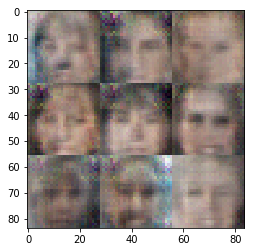

Epoch 2/10... Discriminator Loss: 1.0320... Generator Loss: 0.8364
Epoch 2/10... Discriminator Loss: 1.0047... Generator Loss: 0.9018
Epoch 2/10... Discriminator Loss: 0.0751... Generator Loss: 4.7151
Epoch 2/10... Discriminator Loss: 0.4351... Generator Loss: 7.0205
Epoch 2/10... Discriminator Loss: 0.0170... Generator Loss: 5.7713
Epoch 2/10... Discriminator Loss: 0.0299... Generator Loss: 5.2699
Epoch 2/10... Discriminator Loss: 0.0108... Generator Loss: 7.9320
Epoch 2/10... Discriminator Loss: 0.7321... Generator Loss: 0.9175
Epoch 2/10... Discriminator Loss: 0.3646... Generator Loss: 1.5455
Epoch 2/10... Discriminator Loss: 1.3188... Generator Loss: 0.8600


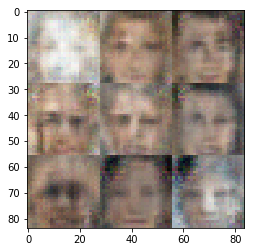

Epoch 2/10... Discriminator Loss: 0.9206... Generator Loss: 1.0545
Epoch 2/10... Discriminator Loss: 1.3758... Generator Loss: 0.6998
Epoch 2/10... Discriminator Loss: 1.3926... Generator Loss: 0.6095
Epoch 2/10... Discriminator Loss: 1.2094... Generator Loss: 0.8264
Epoch 2/10... Discriminator Loss: 1.2108... Generator Loss: 0.8072
Epoch 2/10... Discriminator Loss: 1.3151... Generator Loss: 0.5981
Epoch 2/10... Discriminator Loss: 1.0229... Generator Loss: 0.8588
Epoch 2/10... Discriminator Loss: 1.2092... Generator Loss: 0.8990
Epoch 2/10... Discriminator Loss: 1.1928... Generator Loss: 1.0689
Epoch 2/10... Discriminator Loss: 1.1972... Generator Loss: 0.6374


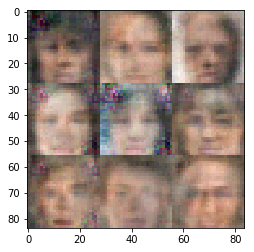

Epoch 2/10... Discriminator Loss: 1.3354... Generator Loss: 1.7524
Epoch 2/10... Discriminator Loss: 1.1123... Generator Loss: 2.8196
Epoch 2/10... Discriminator Loss: 0.4892... Generator Loss: 1.5472
Epoch 2/10... Discriminator Loss: 0.1126... Generator Loss: 2.8873
Epoch 2/10... Discriminator Loss: 0.0058... Generator Loss: 8.2632
Epoch 2/10... Discriminator Loss: 0.0121... Generator Loss: 7.2805
Epoch 2/10... Discriminator Loss: 0.0075... Generator Loss: 7.5556
Epoch 2/10... Discriminator Loss: 0.0210... Generator Loss: 6.3613
Epoch 2/10... Discriminator Loss: 0.0086... Generator Loss: 8.0055
Epoch 2/10... Discriminator Loss: 0.0094... Generator Loss: 6.0780


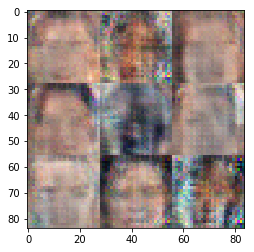

Epoch 2/10... Discriminator Loss: 0.0089... Generator Loss: 8.2171
Epoch 2/10... Discriminator Loss: 0.0036... Generator Loss: 6.4014
Epoch 2/10... Discriminator Loss: 0.0041... Generator Loss: 6.6897
Epoch 2/10... Discriminator Loss: 0.0058... Generator Loss: 6.3204
Epoch 2/10... Discriminator Loss: 0.0174... Generator Loss: 4.4931
Epoch 2/10... Discriminator Loss: 0.0046... Generator Loss: 6.7958
Epoch 2/10... Discriminator Loss: 0.0111... Generator Loss: 5.1353
Epoch 2/10... Discriminator Loss: 0.0069... Generator Loss: 5.6292
Epoch 2/10... Discriminator Loss: 0.0077... Generator Loss: 5.7447
Epoch 2/10... Discriminator Loss: 0.0104... Generator Loss: 5.1917


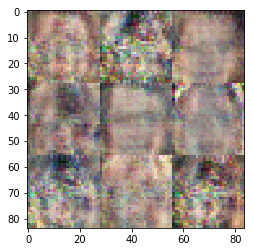

Epoch 2/10... Discriminator Loss: 0.0021... Generator Loss: 7.0782
Epoch 2/10... Discriminator Loss: 0.0049... Generator Loss: 5.8253
Epoch 2/10... Discriminator Loss: 0.0036... Generator Loss: 6.1920
Epoch 2/10... Discriminator Loss: 0.0054... Generator Loss: 5.7493
Epoch 2/10... Discriminator Loss: 0.0026... Generator Loss: 7.7120
Epoch 2/10... Discriminator Loss: 0.0020... Generator Loss: 11.1116
Epoch 2/10... Discriminator Loss: 0.0010... Generator Loss: 9.1947
Epoch 2/10... Discriminator Loss: 0.0008... Generator Loss: 8.7974
Epoch 2/10... Discriminator Loss: 0.0093... Generator Loss: 10.7166
Epoch 2/10... Discriminator Loss: 0.0006... Generator Loss: 9.4838


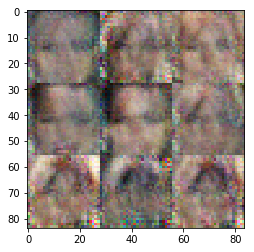

Epoch 2/10... Discriminator Loss: 0.0031... Generator Loss: 6.5756
Epoch 2/10... Discriminator Loss: 0.0025... Generator Loss: 6.5824
Epoch 2/10... Discriminator Loss: 0.0009... Generator Loss: 11.1139
Epoch 2/10... Discriminator Loss: 0.0010... Generator Loss: 7.8833
Epoch 2/10... Discriminator Loss: 0.0014... Generator Loss: 12.0853
Epoch 2/10... Discriminator Loss: 0.0009... Generator Loss: 11.4967
Epoch 2/10... Discriminator Loss: 0.0008... Generator Loss: 7.9744
Epoch 2/10... Discriminator Loss: 0.0007... Generator Loss: 8.1578
Epoch 2/10... Discriminator Loss: 0.0017... Generator Loss: 6.8017
Epoch 2/10... Discriminator Loss: 0.0024... Generator Loss: 6.2800


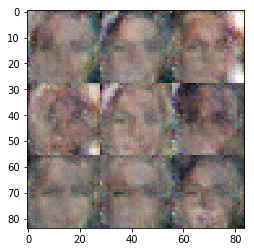

Epoch 2/10... Discriminator Loss: 0.0011... Generator Loss: 7.7288
Epoch 2/10... Discriminator Loss: 0.0020... Generator Loss: 6.7870
Epoch 2/10... Discriminator Loss: 0.0002... Generator Loss: 11.3298
Epoch 2/10... Discriminator Loss: 0.0013... Generator Loss: 7.3048
Epoch 2/10... Discriminator Loss: 0.0032... Generator Loss: 6.3256
Epoch 2/10... Discriminator Loss: 0.0002... Generator Loss: 9.7613
Epoch 2/10... Discriminator Loss: 0.0044... Generator Loss: 5.8100
Epoch 2/10... Discriminator Loss: 0.0002... Generator Loss: 12.1056
Epoch 2/10... Discriminator Loss: 0.0052... Generator Loss: 5.5490
Epoch 2/10... Discriminator Loss: 0.0051... Generator Loss: 5.6207


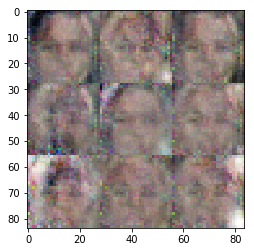

Epoch 2/10... Discriminator Loss: 0.0032... Generator Loss: 6.0841
Epoch 2/10... Discriminator Loss: 0.0014... Generator Loss: 7.3526
Epoch 2/10... Discriminator Loss: 0.0024... Generator Loss: 6.6944
Epoch 2/10... Discriminator Loss: 0.0014... Generator Loss: 13.2399
Epoch 2/10... Discriminator Loss: 0.0378... Generator Loss: 3.8904
Epoch 2/10... Discriminator Loss: 0.9570... Generator Loss: 1.2315
Epoch 2/10... Discriminator Loss: 1.1346... Generator Loss: 6.6545
Epoch 2/10... Discriminator Loss: 0.0404... Generator Loss: 5.2513
Epoch 2/10... Discriminator Loss: 0.0466... Generator Loss: 4.7370
Epoch 2/10... Discriminator Loss: 0.5476... Generator Loss: 1.2476


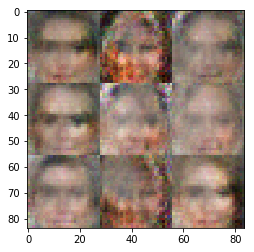

Epoch 2/10... Discriminator Loss: 0.4909... Generator Loss: 1.8560
Epoch 2/10... Discriminator Loss: 0.4521... Generator Loss: 1.4037
Epoch 2/10... Discriminator Loss: 0.5732... Generator Loss: 1.1527
Epoch 2/10... Discriminator Loss: 1.0817... Generator Loss: 0.9668
Epoch 2/10... Discriminator Loss: 2.3477... Generator Loss: 0.1488
Epoch 2/10... Discriminator Loss: 0.7766... Generator Loss: 1.3591
Epoch 2/10... Discriminator Loss: 0.8785... Generator Loss: 1.2273
Epoch 2/10... Discriminator Loss: 1.1696... Generator Loss: 0.8005
Epoch 2/10... Discriminator Loss: 0.6352... Generator Loss: 1.5486
Epoch 2/10... Discriminator Loss: 0.8814... Generator Loss: 2.3366


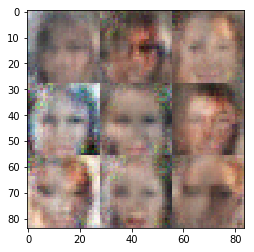

Epoch 2/10... Discriminator Loss: 0.1866... Generator Loss: 6.2852
Epoch 2/10... Discriminator Loss: 0.6203... Generator Loss: 1.4973
Epoch 2/10... Discriminator Loss: 0.9637... Generator Loss: 0.9461
Epoch 2/10... Discriminator Loss: 0.4184... Generator Loss: 2.6506
Epoch 2/10... Discriminator Loss: 0.7952... Generator Loss: 0.9687
Epoch 2/10... Discriminator Loss: 0.0484... Generator Loss: 4.3588
Epoch 2/10... Discriminator Loss: 0.2925... Generator Loss: 3.4036
Epoch 2/10... Discriminator Loss: 0.0305... Generator Loss: 5.3191
Epoch 2/10... Discriminator Loss: 0.2556... Generator Loss: 2.8072
Epoch 2/10... Discriminator Loss: 1.0992... Generator Loss: 1.5843


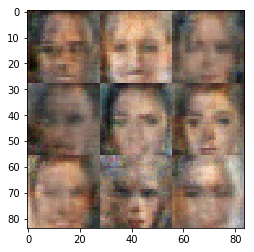

Epoch 2/10... Discriminator Loss: 0.7364... Generator Loss: 1.1172
Epoch 2/10... Discriminator Loss: 0.0058... Generator Loss: 7.9104
Epoch 2/10... Discriminator Loss: 0.0174... Generator Loss: 5.6967
Epoch 2/10... Discriminator Loss: 0.4177... Generator Loss: 1.5115
Epoch 2/10... Discriminator Loss: 0.0222... Generator Loss: 4.4858
Epoch 2/10... Discriminator Loss: 0.0069... Generator Loss: 6.5407
Epoch 2/10... Discriminator Loss: 0.0043... Generator Loss: 7.2816
Epoch 2/10... Discriminator Loss: 0.0068... Generator Loss: 7.4385
Epoch 2/10... Discriminator Loss: 0.0199... Generator Loss: 4.3149
Epoch 2/10... Discriminator Loss: 0.0036... Generator Loss: 10.7120


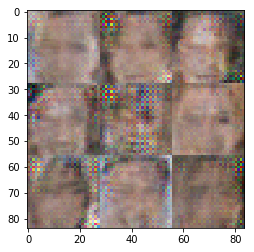

Epoch 2/10... Discriminator Loss: 0.0014... Generator Loss: 8.2531
Epoch 2/10... Discriminator Loss: 0.0022... Generator Loss: 6.5494
Epoch 2/10... Discriminator Loss: 0.0017... Generator Loss: 8.3048
Epoch 2/10... Discriminator Loss: 0.0039... Generator Loss: 6.1137
Epoch 2/10... Discriminator Loss: 0.0009... Generator Loss: 9.2643
Epoch 2/10... Discriminator Loss: 0.0006... Generator Loss: 9.2239
Epoch 3/10... Discriminator Loss: 0.0005... Generator Loss: 9.4436
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 7.7221
Epoch 3/10... Discriminator Loss: 0.0023... Generator Loss: 6.8851
Epoch 3/10... Discriminator Loss: 0.0039... Generator Loss: 6.5008


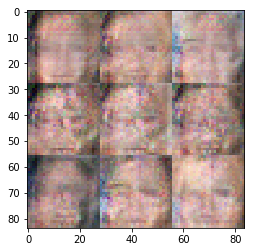

Epoch 3/10... Discriminator Loss: 0.0073... Generator Loss: 5.6943
Epoch 3/10... Discriminator Loss: 0.0093... Generator Loss: 5.6367
Epoch 3/10... Discriminator Loss: 0.0071... Generator Loss: 5.5533
Epoch 3/10... Discriminator Loss: 0.0101... Generator Loss: 5.3562
Epoch 3/10... Discriminator Loss: 0.0038... Generator Loss: 6.0038
Epoch 3/10... Discriminator Loss: 0.0050... Generator Loss: 5.7066
Epoch 3/10... Discriminator Loss: 0.0043... Generator Loss: 5.8077
Epoch 3/10... Discriminator Loss: 0.0045... Generator Loss: 5.7730
Epoch 3/10... Discriminator Loss: 0.0054... Generator Loss: 5.5506
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 6.4615


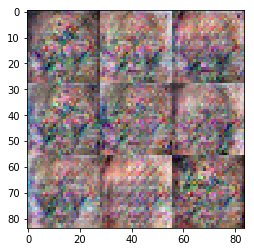

Epoch 3/10... Discriminator Loss: 0.0083... Generator Loss: 5.0913
Epoch 3/10... Discriminator Loss: 0.0058... Generator Loss: 5.4767
Epoch 3/10... Discriminator Loss: 0.0035... Generator Loss: 5.9981
Epoch 3/10... Discriminator Loss: 0.0036... Generator Loss: 5.9761
Epoch 3/10... Discriminator Loss: 0.0040... Generator Loss: 5.9577
Epoch 3/10... Discriminator Loss: 0.0039... Generator Loss: 5.8786
Epoch 3/10... Discriminator Loss: 0.0036... Generator Loss: 5.9644
Epoch 3/10... Discriminator Loss: 0.0043... Generator Loss: 5.8046
Epoch 3/10... Discriminator Loss: 0.0046... Generator Loss: 5.6208
Epoch 3/10... Discriminator Loss: 0.0017... Generator Loss: 6.7402


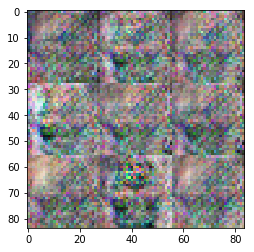

Epoch 3/10... Discriminator Loss: 0.0031... Generator Loss: 6.3624
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 6.2817
Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 8.0853
Epoch 3/10... Discriminator Loss: 0.0028... Generator Loss: 6.3000
Epoch 3/10... Discriminator Loss: 0.0017... Generator Loss: 6.7127
Epoch 3/10... Discriminator Loss: 0.0023... Generator Loss: 6.4507
Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 7.7571
Epoch 3/10... Discriminator Loss: 0.0042... Generator Loss: 5.9926
Epoch 3/10... Discriminator Loss: 0.0021... Generator Loss: 6.9019
Epoch 3/10... Discriminator Loss: 0.0024... Generator Loss: 6.5203


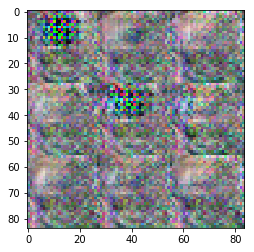

Epoch 3/10... Discriminator Loss: 0.0029... Generator Loss: 6.3206
Epoch 3/10... Discriminator Loss: 0.0013... Generator Loss: 7.1408
Epoch 3/10... Discriminator Loss: 0.0013... Generator Loss: 7.1604
Epoch 3/10... Discriminator Loss: 0.0020... Generator Loss: 6.8018
Epoch 3/10... Discriminator Loss: 0.0031... Generator Loss: 6.4160
Epoch 3/10... Discriminator Loss: 0.0023... Generator Loss: 6.5402
Epoch 3/10... Discriminator Loss: 0.0029... Generator Loss: 6.4514
Epoch 3/10... Discriminator Loss: 0.0035... Generator Loss: 6.2668
Epoch 3/10... Discriminator Loss: 0.0004... Generator Loss: 8.4555
Epoch 3/10... Discriminator Loss: 0.0023... Generator Loss: 6.7652


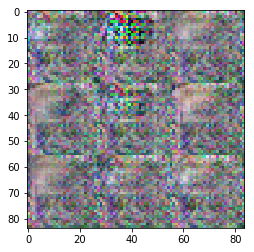

Epoch 3/10... Discriminator Loss: 0.0032... Generator Loss: 6.5441
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.4878
Epoch 3/10... Discriminator Loss: 0.0006... Generator Loss: 8.2761
Epoch 3/10... Discriminator Loss: 0.0029... Generator Loss: 6.4491
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.5196
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.5738
Epoch 3/10... Discriminator Loss: 0.0009... Generator Loss: 7.6784
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.8151
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.6666
Epoch 3/10... Discriminator Loss: 0.0014... Generator Loss: 7.1544


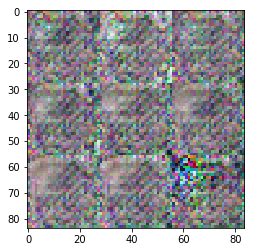

Epoch 3/10... Discriminator Loss: 0.0003... Generator Loss: 9.1680
Epoch 3/10... Discriminator Loss: 0.0023... Generator Loss: 6.8703
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.5080
Epoch 3/10... Discriminator Loss: 0.0018... Generator Loss: 7.0383
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.5124
Epoch 3/10... Discriminator Loss: 0.0018... Generator Loss: 7.1300
Epoch 3/10... Discriminator Loss: 0.0020... Generator Loss: 7.0773
Epoch 3/10... Discriminator Loss: 0.0018... Generator Loss: 7.1561
Epoch 3/10... Discriminator Loss: 0.0006... Generator Loss: 8.1609
Epoch 3/10... Discriminator Loss: 0.0001... Generator Loss: 10.3918


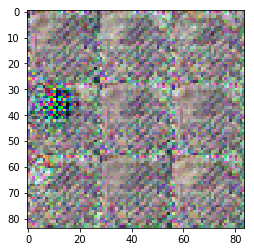

Epoch 3/10... Discriminator Loss: 0.0017... Generator Loss: 7.4070
Epoch 3/10... Discriminator Loss: 0.0026... Generator Loss: 7.0724
Epoch 3/10... Discriminator Loss: 0.0009... Generator Loss: 8.0096
Epoch 3/10... Discriminator Loss: 0.0024... Generator Loss: 7.2949
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 7.4559
Epoch 3/10... Discriminator Loss: 0.0022... Generator Loss: 7.5406
Epoch 3/10... Discriminator Loss: 0.0048... Generator Loss: 6.6524
Epoch 3/10... Discriminator Loss: 0.0050... Generator Loss: 6.3897
Epoch 3/10... Discriminator Loss: 0.0043... Generator Loss: 6.4598
Epoch 3/10... Discriminator Loss: 0.0049... Generator Loss: 6.2963


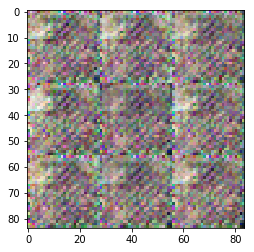

Epoch 3/10... Discriminator Loss: 0.0041... Generator Loss: 6.2610
Epoch 3/10... Discriminator Loss: 0.0036... Generator Loss: 6.4708
Epoch 3/10... Discriminator Loss: 0.0054... Generator Loss: 5.9742
Epoch 3/10... Discriminator Loss: 0.0002... Generator Loss: 9.4495
Epoch 3/10... Discriminator Loss: 0.0045... Generator Loss: 6.0525
Epoch 3/10... Discriminator Loss: 0.0047... Generator Loss: 5.9749
Epoch 3/10... Discriminator Loss: 0.0014... Generator Loss: 7.1822
Epoch 3/10... Discriminator Loss: 0.0033... Generator Loss: 6.1433
Epoch 3/10... Discriminator Loss: 0.0021... Generator Loss: 6.6916
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 6.3928


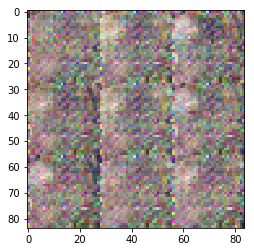

Epoch 3/10... Discriminator Loss: 0.0022... Generator Loss: 6.5455
Epoch 3/10... Discriminator Loss: 0.0017... Generator Loss: 6.8616
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 6.3981
Epoch 3/10... Discriminator Loss: 0.0035... Generator Loss: 6.1036
Epoch 3/10... Discriminator Loss: 0.0004... Generator Loss: 8.5224
Epoch 3/10... Discriminator Loss: 0.0005... Generator Loss: 8.1362
Epoch 3/10... Discriminator Loss: 0.0041... Generator Loss: 5.8827
Epoch 3/10... Discriminator Loss: 0.0037... Generator Loss: 5.9827
Epoch 3/10... Discriminator Loss: 0.0029... Generator Loss: 6.2924
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.1780


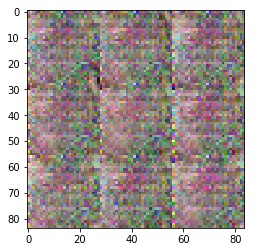

Epoch 3/10... Discriminator Loss: 0.0024... Generator Loss: 6.4296
Epoch 3/10... Discriminator Loss: 0.0036... Generator Loss: 6.0828
Epoch 3/10... Discriminator Loss: 0.0001... Generator Loss: 9.5372
Epoch 3/10... Discriminator Loss: 0.0013... Generator Loss: 7.0803
Epoch 3/10... Discriminator Loss: 0.0000... Generator Loss: 11.2178
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.4333
Epoch 3/10... Discriminator Loss: 0.0014... Generator Loss: 7.0518
Epoch 3/10... Discriminator Loss: 0.0021... Generator Loss: 6.6298
Epoch 3/10... Discriminator Loss: 0.0024... Generator Loss: 6.4974
Epoch 3/10... Discriminator Loss: 0.0038... Generator Loss: 5.9827


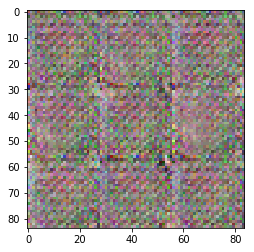

Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.2223
Epoch 3/10... Discriminator Loss: 0.0019... Generator Loss: 6.5754
Epoch 3/10... Discriminator Loss: 0.0032... Generator Loss: 6.0582
Epoch 3/10... Discriminator Loss: 0.0025... Generator Loss: 6.2820
Epoch 3/10... Discriminator Loss: 0.0026... Generator Loss: 6.1920
Epoch 3/10... Discriminator Loss: 0.0013... Generator Loss: 6.9224
Epoch 3/10... Discriminator Loss: 0.0019... Generator Loss: 6.4607
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.2709
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.0729
Epoch 3/10... Discriminator Loss: 0.0005... Generator Loss: 7.8772


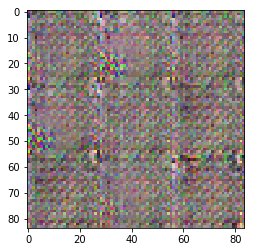

Epoch 3/10... Discriminator Loss: 0.0026... Generator Loss: 6.1562
Epoch 3/10... Discriminator Loss: 0.0015... Generator Loss: 6.7058
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.4493
Epoch 3/10... Discriminator Loss: 0.0021... Generator Loss: 6.3734
Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 7.3810
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.2285
Epoch 3/10... Discriminator Loss: 0.0016... Generator Loss: 6.6100
Epoch 3/10... Discriminator Loss: 0.0014... Generator Loss: 6.7718
Epoch 3/10... Discriminator Loss: 0.0002... Generator Loss: 9.1974
Epoch 3/10... Discriminator Loss: 0.0015... Generator Loss: 6.7351


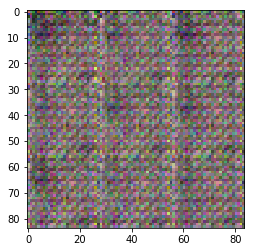

Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 7.5854
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 7.0198
Epoch 3/10... Discriminator Loss: 0.0017... Generator Loss: 6.5794
Epoch 3/10... Discriminator Loss: 0.0021... Generator Loss: 6.5385
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.1437
Epoch 3/10... Discriminator Loss: 0.0009... Generator Loss: 7.3281
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.5156
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 6.9329
Epoch 3/10... Discriminator Loss: 0.0013... Generator Loss: 6.9865
Epoch 3/10... Discriminator Loss: 0.0015... Generator Loss: 6.8621


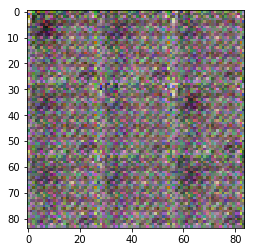

Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.2044
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.4486
Epoch 3/10... Discriminator Loss: 0.0006... Generator Loss: 7.9294
Epoch 3/10... Discriminator Loss: 0.0008... Generator Loss: 7.4490
Epoch 3/10... Discriminator Loss: 0.0014... Generator Loss: 7.0640
Epoch 3/10... Discriminator Loss: 0.0004... Generator Loss: 8.0738
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.2335
Epoch 3/10... Discriminator Loss: 0.0001... Generator Loss: 9.5264
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 7.6306
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.3911


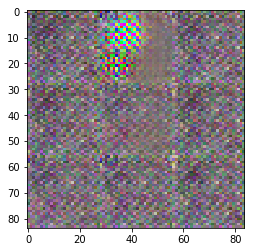

Epoch 3/10... Discriminator Loss: 0.0002... Generator Loss: 9.0843
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.3677
Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 7.6449
Epoch 3/10... Discriminator Loss: 0.0010... Generator Loss: 7.2683
Epoch 3/10... Discriminator Loss: 0.0002... Generator Loss: 8.7425
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.2493
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 7.1484
Epoch 3/10... Discriminator Loss: 0.0007... Generator Loss: 7.6441
Epoch 3/10... Discriminator Loss: 0.0011... Generator Loss: 7.1727
Epoch 3/10... Discriminator Loss: 0.0006... Generator Loss: 7.8520


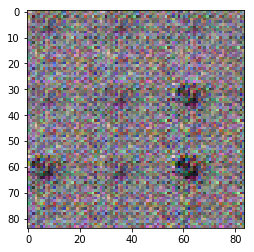

Epoch 3/10... Discriminator Loss: 0.0016... Generator Loss: 6.8524
Epoch 3/10... Discriminator Loss: 0.0005... Generator Loss: 8.0096
Epoch 3/10... Discriminator Loss: 0.0012... Generator Loss: 7.1805
Epoch 3/10... Discriminator Loss: 0.0002... Generator Loss: 9.1929
Epoch 4/10... Discriminator Loss: 0.0010... Generator Loss: 7.2056
Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.3880
Epoch 4/10... Discriminator Loss: 0.0007... Generator Loss: 7.6106
Epoch 4/10... Discriminator Loss: 0.0013... Generator Loss: 7.0690
Epoch 4/10... Discriminator Loss: 0.0012... Generator Loss: 7.1922
Epoch 4/10... Discriminator Loss: 0.0010... Generator Loss: 7.2532


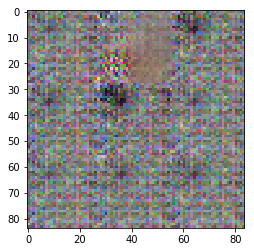

Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.4151
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.5035
Epoch 4/10... Discriminator Loss: 0.0010... Generator Loss: 7.3541
Epoch 4/10... Discriminator Loss: 0.0012... Generator Loss: 7.0685
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 10.9350
Epoch 4/10... Discriminator Loss: 0.0010... Generator Loss: 7.3393
Epoch 4/10... Discriminator Loss: 0.0011... Generator Loss: 7.1987
Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.3895
Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.5692
Epoch 4/10... Discriminator Loss: 0.0013... Generator Loss: 7.1426


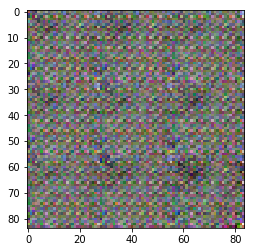

Epoch 4/10... Discriminator Loss: 0.0007... Generator Loss: 7.6781
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7318
Epoch 4/10... Discriminator Loss: 0.0012... Generator Loss: 7.0496
Epoch 4/10... Discriminator Loss: 0.0011... Generator Loss: 7.2604
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7421
Epoch 4/10... Discriminator Loss: 0.0011... Generator Loss: 7.1290
Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.3613
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.0871
Epoch 4/10... Discriminator Loss: 0.0007... Generator Loss: 7.6478
Epoch 4/10... Discriminator Loss: 0.0010... Generator Loss: 7.3787


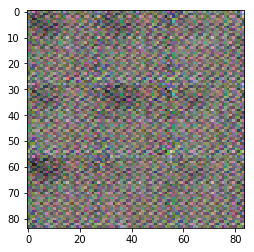

Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.4951
Epoch 4/10... Discriminator Loss: 0.0016... Generator Loss: 6.9273
Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.4224
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.2702
Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.4749
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 9.0064
Epoch 4/10... Discriminator Loss: 0.0007... Generator Loss: 7.6784
Epoch 4/10... Discriminator Loss: 0.0012... Generator Loss: 7.1233
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3489
Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.4101


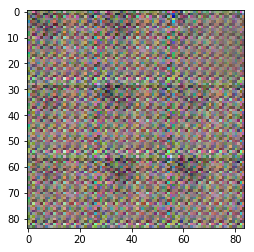

Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.5099
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 10.3809
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.3220
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7876
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 9.0467
Epoch 4/10... Discriminator Loss: 0.0011... Generator Loss: 7.2465
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 8.0598
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7035
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4090
Epoch 4/10... Discriminator Loss: 0.0009... Generator Loss: 7.3932


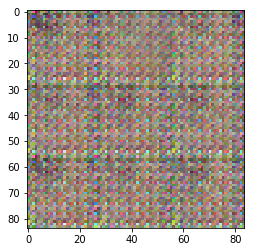

Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.6915
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.9810
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7659
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7463
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 8.0131
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7119
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.9579
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7169
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.2441
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4154


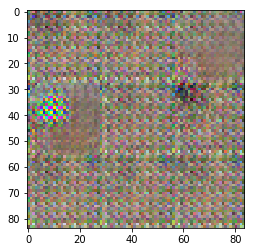

Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.0049
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.9940
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 11.9505
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2897
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7397
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7308
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.2115
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4257
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.0726
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4686


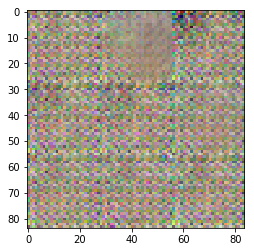

Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.3041
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3913
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.9990
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4315
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 10.4785
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.9609
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.8437
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.8155
Epoch 4/10... Discriminator Loss: 0.0006... Generator Loss: 7.7356
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.2456


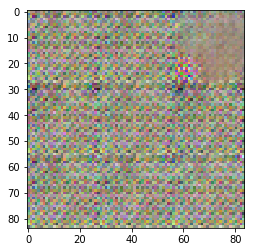

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.5586
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4422
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2990
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4237
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.5026
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2421
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9553
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6914
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9706
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7785


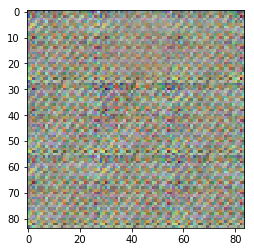

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.5754
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9529
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7021
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.1619
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.5626
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 9.0177
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.5945
Epoch 4/10... Discriminator Loss: 0.0008... Generator Loss: 7.4665
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3950
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.0141


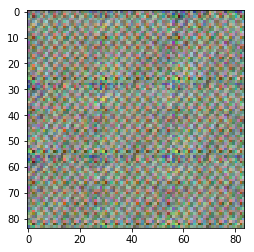

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6596
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.4017
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.1936
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 8.0119
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6912
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4938
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7473
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4186
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 11.3635
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.1093


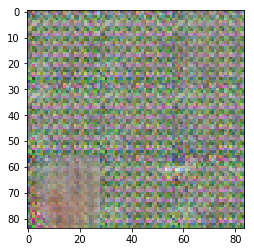

Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.2346
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.8729
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.2482
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 12.3599
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3583
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9054
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.8138
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3415
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 9.0483
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4106


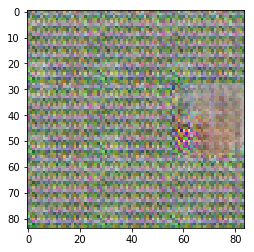

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7227
Epoch 4/10... Discriminator Loss: 0.0005... Generator Loss: 7.7746
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6416
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 10.0655
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.1032
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7157
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.2585
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3518
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 9.0054
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 10.2306


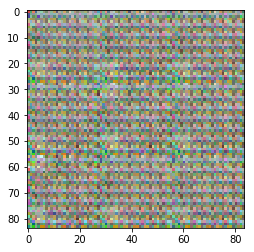

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.8047
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3380
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 14.5886
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.9568
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6986
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.5583
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9122
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.8349
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.9679
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.1832


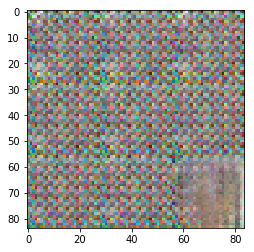

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.8028
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.3790
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.0506
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2551
Epoch 4/10... Discriminator Loss: 0.0004... Generator Loss: 8.1525
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.5645
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 10.3031
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.4986
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 10.6462
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.7646


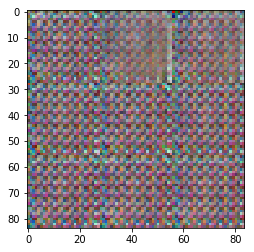

Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2651
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.1577
Epoch 4/10... Discriminator Loss: 0.0003... Generator Loss: 8.2230
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.2863
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.0189
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 8.9747
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 14.2717
Epoch 4/10... Discriminator Loss: 0.0001... Generator Loss: 9.0685
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.8422
Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6776


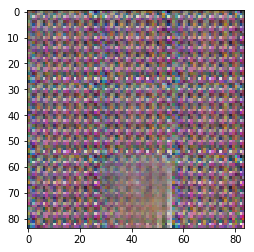

Epoch 4/10... Discriminator Loss: 0.0002... Generator Loss: 8.6361
Epoch 4/10... Discriminator Loss: 0.0000... Generator Loss: 10.7650
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.0773
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1105
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.0164
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.9458
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1902
Epoch 5/10... Discriminator Loss: 0.0004... Generator Loss: 8.1639
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 8.9429
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1954


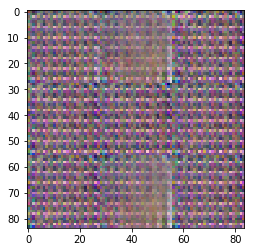

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.0787
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 8.8487
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.4690
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1725
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.7938
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9155
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.2319
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8231
Epoch 5/10... Discriminator Loss: 0.0003... Generator Loss: 8.7097
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 9.2915
Epoch 5/10... Discriminator Loss: 0.0003... Generator Loss: 8.8230
Epoch 5/10... Discriminator Loss: 0.0003... Generator Loss: 8.4436
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7293
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 9.1285
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss

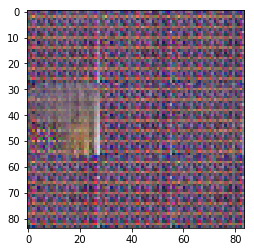

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.1101
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.0802
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 13.1201
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5859
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8566
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.5783
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.3128
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7961
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2195
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6821


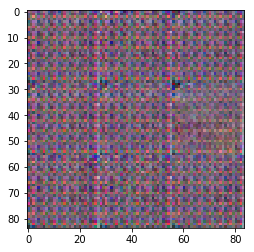

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 14.2467
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.7179
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.7523
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 16.2062
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4011
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5578
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6506
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 16.2111
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.3423
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4376


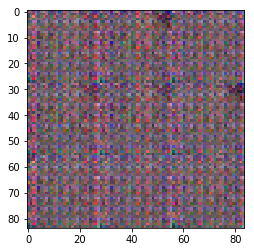

Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.4629
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4086
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.1294
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.1583
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9627
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.2264
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6430
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.4076
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7278
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.7422


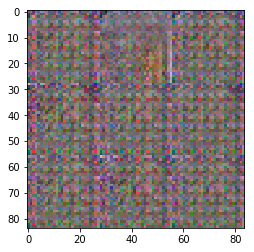

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.6148
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.0201
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6343
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.1802
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.8387
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.4012
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8782
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9440
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2156
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9398


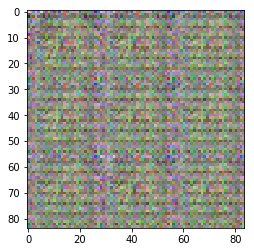

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 13.4937
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.7113
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1918
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.2523
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 9.3707
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 9.5415
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6707
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 9.1758
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.6746
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9144


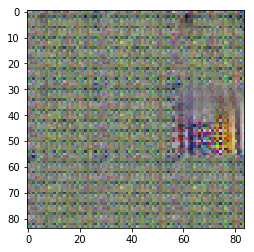

Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6180
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.0449
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.4784
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.0068
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.3287
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.0663
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.2641
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.9338
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.4946
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.1954


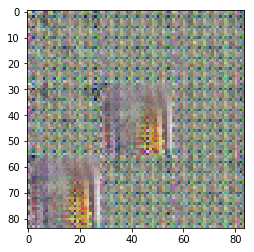

Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6363
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.2048
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9844
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8081
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9344
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 8.7648
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5664
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.9108
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9072
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.1283


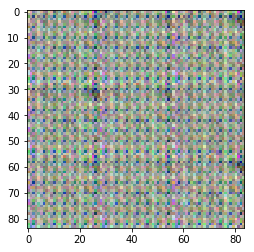

Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5627
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6368
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.7793
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.6518
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.3818
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2734
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6525
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7694
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.6266
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9784


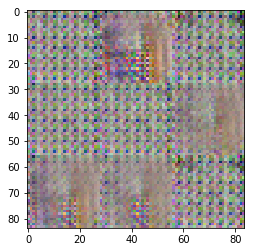

Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.0317
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5632
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2421
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.9687
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.1835
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.1360
Epoch 5/10... Discriminator Loss: 0.0002... Generator Loss: 8.9685
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6918
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7042
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 10.0221


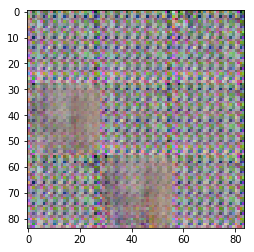

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 13.3184
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4318
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8319
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4338
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.1051
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.4130
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.0011
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5140
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9658
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.8833


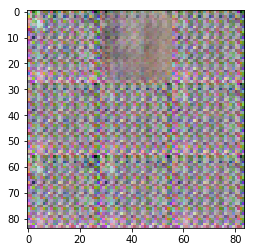

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.5592
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.9394
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.4394
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.6394
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 12.5955
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.5377
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4845
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.0686
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4643
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.5186


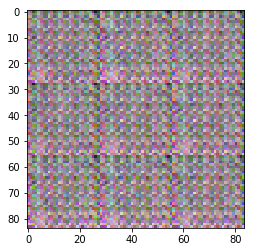

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2453
Epoch 5/10... Discriminator Loss: 0.0001... Generator Loss: 9.7836
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.8588
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.7569
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.1271
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.5709
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 17.7709
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.0820
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.5636
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.4296


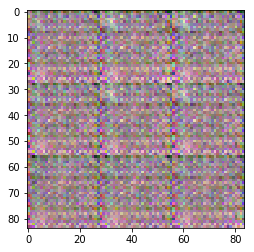

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.4769
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 13.3157
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.8613
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.8767
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2037
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2967
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.6279
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.3395
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.4517
Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 10.2980


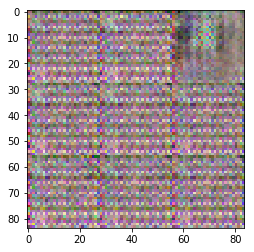

Epoch 5/10... Discriminator Loss: 0.0000... Generator Loss: 11.6391
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.1242
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2013
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.0586
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.0381
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.8950
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6178
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7718
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.9342
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7057


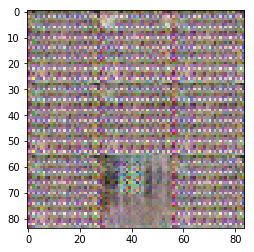

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6957
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.9179
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2224
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2796
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7036
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.0047
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.3956
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.8445
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5902
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.0171


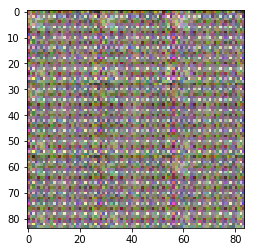

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5635
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 9.9750
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2354
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.4562
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 9.6069
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2045
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.5938
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5852
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.3213
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2320


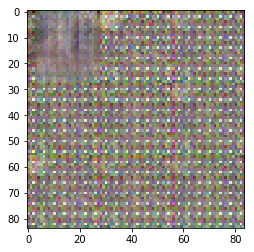

Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.0347
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.3364
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.4108
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.4038
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5670
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.3999
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.6581
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2410
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.0469


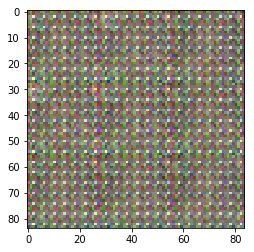

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2305
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.0848
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2466
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 9.8515
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.1981
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7918
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 16.5022
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.7589
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2577
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2603


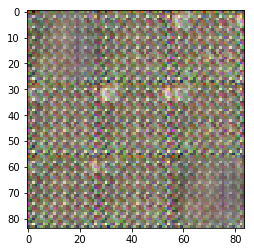

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7588
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.8525
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.9692
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 9.9375
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 9.8381
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5196
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 15.3753
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7270
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5573
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.4784


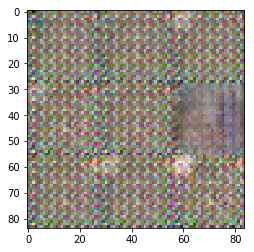

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.1358
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.4546
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5581
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.3934
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.0249
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.5692
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.3601
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.7247
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2001
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.4006


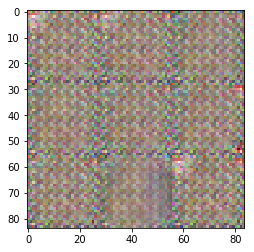

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.8747
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.7137
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.3415
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2453
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.6120
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6708
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.9585
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.3807
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.0265
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.2263


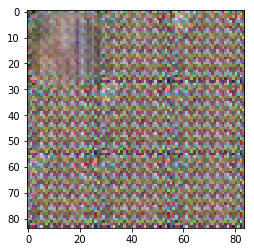

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.4284
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.2816
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.7751
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.6607
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.9437
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.6645
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6623
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.5223
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6456
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2061


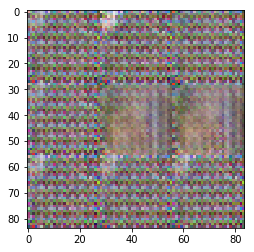

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.5028
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.4465
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.2139
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 18.1658
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.9806
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.8037
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 10.6449
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 21.0873
Epoch 6/10... Discriminator Loss: 0.0001... Generator Loss: 10.0217
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 16.7681


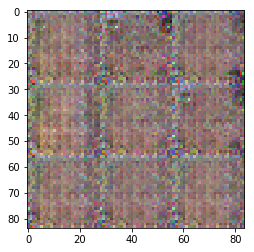

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.9134
Epoch 6/10... Discriminator Loss: 0.0022... Generator Loss: 20.8441
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.4166
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 19.5203
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.6189
Epoch 6/10... Discriminator Loss: 0.0002... Generator Loss: 10.7782
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 20.4280
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 15.4600
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.9901
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.4276


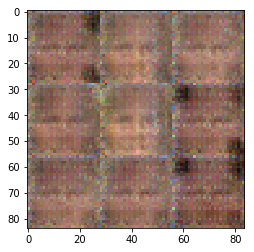

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.8167
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.8692
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.8207
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 14.9829
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.2549
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.5410
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.5300
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 15.5732
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 13.4415
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.5617


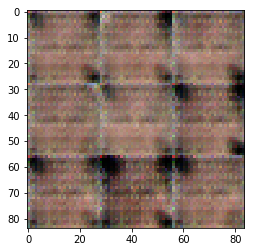

Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 14.2034
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 24.5587
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 14.8757
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 11.7550
Epoch 6/10... Discriminator Loss: 0.0000... Generator Loss: 12.9519
Epoch 6/10... Discriminator Loss: 1.2356... Generator Loss: 5.3871
Epoch 6/10... Discriminator Loss: 1.9456... Generator Loss: 2.3249
Epoch 6/10... Discriminator Loss: 1.0320... Generator Loss: 1.4775
Epoch 6/10... Discriminator Loss: 2.4863... Generator Loss: 2.3735
Epoch 6/10... Discriminator Loss: 1.0779... Generator Loss: 1.5221


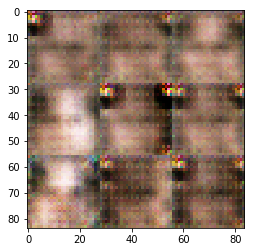

Epoch 6/10... Discriminator Loss: 0.8915... Generator Loss: 2.6485
Epoch 6/10... Discriminator Loss: 1.5772... Generator Loss: 1.1356
Epoch 6/10... Discriminator Loss: 1.2276... Generator Loss: 0.8787
Epoch 6/10... Discriminator Loss: 0.8312... Generator Loss: 1.6005
Epoch 6/10... Discriminator Loss: 0.9333... Generator Loss: 1.0123
Epoch 6/10... Discriminator Loss: 1.5902... Generator Loss: 0.4047
Epoch 6/10... Discriminator Loss: 0.8616... Generator Loss: 0.9158
Epoch 6/10... Discriminator Loss: 1.1324... Generator Loss: 0.6581
Epoch 6/10... Discriminator Loss: 0.6192... Generator Loss: 1.0837
Epoch 6/10... Discriminator Loss: 1.8422... Generator Loss: 0.2675


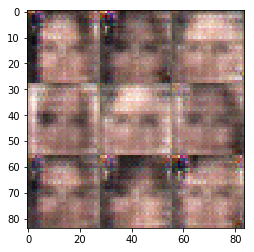

Epoch 6/10... Discriminator Loss: 1.5338... Generator Loss: 0.5220
Epoch 6/10... Discriminator Loss: 0.8240... Generator Loss: 0.9711
Epoch 6/10... Discriminator Loss: 2.1659... Generator Loss: 0.2268
Epoch 6/10... Discriminator Loss: 1.1448... Generator Loss: 0.7185
Epoch 6/10... Discriminator Loss: 0.9030... Generator Loss: 1.8979
Epoch 6/10... Discriminator Loss: 1.5756... Generator Loss: 0.3622
Epoch 6/10... Discriminator Loss: 1.0006... Generator Loss: 2.3212
Epoch 6/10... Discriminator Loss: 1.6600... Generator Loss: 0.4961
Epoch 6/10... Discriminator Loss: 1.2313... Generator Loss: 0.6118
Epoch 6/10... Discriminator Loss: 1.0713... Generator Loss: 0.6818


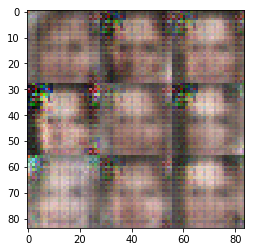

Epoch 6/10... Discriminator Loss: 1.0578... Generator Loss: 1.8802
Epoch 6/10... Discriminator Loss: 1.6475... Generator Loss: 3.0583
Epoch 6/10... Discriminator Loss: 0.8758... Generator Loss: 2.5897
Epoch 6/10... Discriminator Loss: 0.8557... Generator Loss: 1.4382
Epoch 6/10... Discriminator Loss: 0.8706... Generator Loss: 1.0062
Epoch 6/10... Discriminator Loss: 0.8717... Generator Loss: 1.0730
Epoch 6/10... Discriminator Loss: 0.7233... Generator Loss: 1.0878
Epoch 6/10... Discriminator Loss: 0.8510... Generator Loss: 1.4187
Epoch 6/10... Discriminator Loss: 1.0441... Generator Loss: 1.2688
Epoch 7/10... Discriminator Loss: 0.9885... Generator Loss: 1.2592


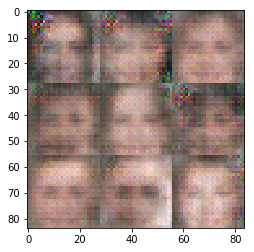

Epoch 7/10... Discriminator Loss: 0.9782... Generator Loss: 1.7861
Epoch 7/10... Discriminator Loss: 1.3886... Generator Loss: 1.9269
Epoch 7/10... Discriminator Loss: 0.9167... Generator Loss: 1.0292
Epoch 7/10... Discriminator Loss: 1.3401... Generator Loss: 0.4041
Epoch 7/10... Discriminator Loss: 1.1655... Generator Loss: 0.6221
Epoch 7/10... Discriminator Loss: 1.2595... Generator Loss: 0.4340
Epoch 7/10... Discriminator Loss: 0.9287... Generator Loss: 1.3016
Epoch 7/10... Discriminator Loss: 0.3122... Generator Loss: 1.6622
Epoch 7/10... Discriminator Loss: 0.6070... Generator Loss: 3.4014
Epoch 7/10... Discriminator Loss: 0.9408... Generator Loss: 0.6312


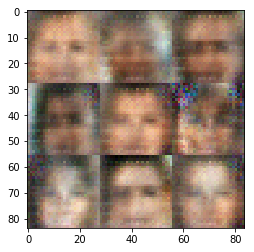

Epoch 7/10... Discriminator Loss: 0.1243... Generator Loss: 3.0696
Epoch 7/10... Discriminator Loss: 0.9610... Generator Loss: 0.7382
Epoch 7/10... Discriminator Loss: 0.6431... Generator Loss: 1.0368
Epoch 7/10... Discriminator Loss: 0.0929... Generator Loss: 5.2219
Epoch 7/10... Discriminator Loss: 0.0392... Generator Loss: 5.0701
Epoch 7/10... Discriminator Loss: 0.5143... Generator Loss: 1.4181
Epoch 7/10... Discriminator Loss: 0.2074... Generator Loss: 5.0517
Epoch 7/10... Discriminator Loss: 0.9687... Generator Loss: 0.7182
Epoch 7/10... Discriminator Loss: 0.1028... Generator Loss: 4.6223
Epoch 7/10... Discriminator Loss: 0.1151... Generator Loss: 2.8623


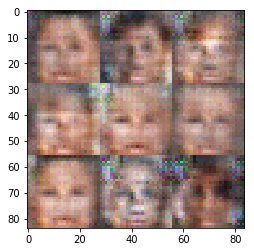

Epoch 7/10... Discriminator Loss: 0.0715... Generator Loss: 5.4207
Epoch 7/10... Discriminator Loss: 1.9650... Generator Loss: 7.2882
Epoch 7/10... Discriminator Loss: 0.0258... Generator Loss: 5.2136
Epoch 7/10... Discriminator Loss: 1.8874... Generator Loss: 1.4212
Epoch 7/10... Discriminator Loss: 0.2732... Generator Loss: 3.5544
Epoch 7/10... Discriminator Loss: 0.0749... Generator Loss: 8.6895
Epoch 7/10... Discriminator Loss: 0.0293... Generator Loss: 7.6945
Epoch 7/10... Discriminator Loss: 0.0489... Generator Loss: 6.9798
Epoch 7/10... Discriminator Loss: 0.0419... Generator Loss: 4.3235


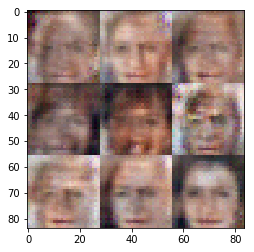

Epoch 7/10... Discriminator Loss: 0.4997... Generator Loss: 1.3554
Epoch 7/10... Discriminator Loss: 0.0567... Generator Loss: 7.0899
Epoch 7/10... Discriminator Loss: 0.1013... Generator Loss: 5.5214
Epoch 7/10... Discriminator Loss: 0.2238... Generator Loss: 1.9618
Epoch 7/10... Discriminator Loss: 0.0346... Generator Loss: 8.0033
Epoch 7/10... Discriminator Loss: 0.0853... Generator Loss: 2.9782
Epoch 7/10... Discriminator Loss: 0.1551... Generator Loss: 8.8697
Epoch 7/10... Discriminator Loss: 0.0232... Generator Loss: 6.6739
Epoch 7/10... Discriminator Loss: 0.3615... Generator Loss: 1.5116
Epoch 7/10... Discriminator Loss: 0.0278... Generator Loss: 6.0881


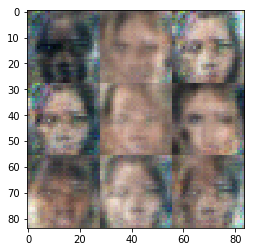

Epoch 7/10... Discriminator Loss: 0.0397... Generator Loss: 6.7061
Epoch 7/10... Discriminator Loss: 1.0007... Generator Loss: 8.6575
Epoch 7/10... Discriminator Loss: 0.5174... Generator Loss: 1.3365
Epoch 7/10... Discriminator Loss: 0.0618... Generator Loss: 4.2075
Epoch 7/10... Discriminator Loss: 2.8230... Generator Loss: 0.0952
Epoch 7/10... Discriminator Loss: 0.5503... Generator Loss: 1.1375
Epoch 7/10... Discriminator Loss: 0.2255... Generator Loss: 1.9285
Epoch 7/10... Discriminator Loss: 1.0623... Generator Loss: 9.3294
Epoch 7/10... Discriminator Loss: 0.8164... Generator Loss: 0.9259
Epoch 7/10... Discriminator Loss: 0.0819... Generator Loss: 5.7686


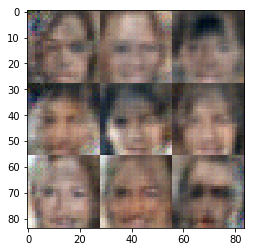

Epoch 7/10... Discriminator Loss: 0.1307... Generator Loss: 2.4509
Epoch 7/10... Discriminator Loss: 0.1317... Generator Loss: 2.6869
Epoch 7/10... Discriminator Loss: 0.1060... Generator Loss: 3.1596
Epoch 7/10... Discriminator Loss: 0.5796... Generator Loss: 3.4858
Epoch 7/10... Discriminator Loss: 0.1020... Generator Loss: 4.9784
Epoch 7/10... Discriminator Loss: 0.0500... Generator Loss: 4.2433
Epoch 7/10... Discriminator Loss: 0.0814... Generator Loss: 3.1528
Epoch 7/10... Discriminator Loss: 1.8804... Generator Loss: 2.1572
Epoch 7/10... Discriminator Loss: 0.5167... Generator Loss: 6.2090
Epoch 7/10... Discriminator Loss: 0.1310... Generator Loss: 3.1939


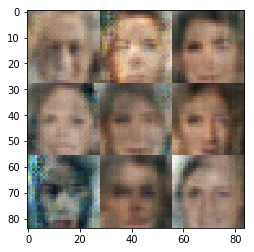

Epoch 7/10... Discriminator Loss: 0.1525... Generator Loss: 2.8831
Epoch 7/10... Discriminator Loss: 0.1129... Generator Loss: 7.4381
Epoch 7/10... Discriminator Loss: 1.6179... Generator Loss: 0.2945
Epoch 7/10... Discriminator Loss: 5.1685... Generator Loss: 7.9117
Epoch 7/10... Discriminator Loss: 0.1088... Generator Loss: 3.1968
Epoch 7/10... Discriminator Loss: 0.3056... Generator Loss: 1.6828
Epoch 7/10... Discriminator Loss: 0.4334... Generator Loss: 1.3990
Epoch 7/10... Discriminator Loss: 1.4682... Generator Loss: 0.7321
Epoch 7/10... Discriminator Loss: 0.0454... Generator Loss: 7.5688
Epoch 7/10... Discriminator Loss: 0.0567... Generator Loss: 5.9752


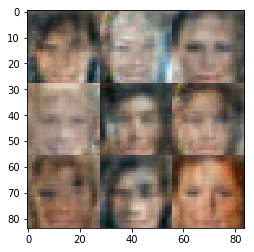

Epoch 7/10... Discriminator Loss: 0.1997... Generator Loss: 2.4270
Epoch 7/10... Discriminator Loss: 2.7034... Generator Loss: 4.9787
Epoch 7/10... Discriminator Loss: 1.8765... Generator Loss: 7.2093
Epoch 7/10... Discriminator Loss: 0.4526... Generator Loss: 1.4159
Epoch 7/10... Discriminator Loss: 0.0615... Generator Loss: 3.9410
Epoch 7/10... Discriminator Loss: 0.1139... Generator Loss: 6.1243
Epoch 7/10... Discriminator Loss: 0.1805... Generator Loss: 2.6852
Epoch 7/10... Discriminator Loss: 0.0857... Generator Loss: 3.7421
Epoch 7/10... Discriminator Loss: 0.0787... Generator Loss: 6.3547
Epoch 7/10... Discriminator Loss: 0.1734... Generator Loss: 5.9519


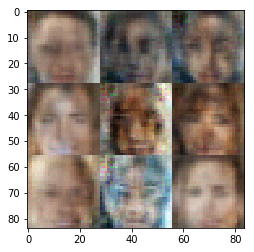

Epoch 7/10... Discriminator Loss: 0.3828... Generator Loss: 1.5966
Epoch 7/10... Discriminator Loss: 0.1979... Generator Loss: 2.2544
Epoch 7/10... Discriminator Loss: 0.0419... Generator Loss: 6.3923
Epoch 7/10... Discriminator Loss: 0.1484... Generator Loss: 3.3999
Epoch 7/10... Discriminator Loss: 0.1499... Generator Loss: 2.6103
Epoch 7/10... Discriminator Loss: 3.5975... Generator Loss: 1.8846
Epoch 7/10... Discriminator Loss: 0.0692... Generator Loss: 6.4160
Epoch 7/10... Discriminator Loss: 0.6136... Generator Loss: 1.1631
Epoch 7/10... Discriminator Loss: 0.6104... Generator Loss: 1.1059
Epoch 7/10... Discriminator Loss: 0.5387... Generator Loss: 1.4906


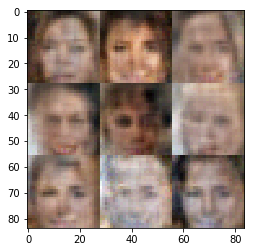

Epoch 7/10... Discriminator Loss: 0.4386... Generator Loss: 3.5985
Epoch 7/10... Discriminator Loss: 0.1354... Generator Loss: 4.2087
Epoch 7/10... Discriminator Loss: 0.0746... Generator Loss: 7.0201
Epoch 7/10... Discriminator Loss: 0.2824... Generator Loss: 3.2095
Epoch 7/10... Discriminator Loss: 0.1266... Generator Loss: 6.2569
Epoch 7/10... Discriminator Loss: 0.0934... Generator Loss: 4.1475
Epoch 7/10... Discriminator Loss: 0.0189... Generator Loss: 7.1621
Epoch 7/10... Discriminator Loss: 0.0786... Generator Loss: 6.4969
Epoch 7/10... Discriminator Loss: 1.2833... Generator Loss: 0.4717
Epoch 7/10... Discriminator Loss: 0.1415... Generator Loss: 3.9088


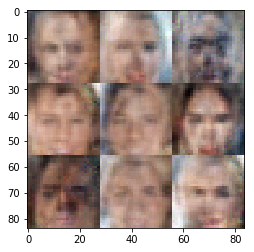

Epoch 7/10... Discriminator Loss: 0.0612... Generator Loss: 3.6892
Epoch 7/10... Discriminator Loss: 1.2373... Generator Loss: 4.0534
Epoch 7/10... Discriminator Loss: 0.2406... Generator Loss: 3.4915
Epoch 7/10... Discriminator Loss: 0.2694... Generator Loss: 1.8677
Epoch 7/10... Discriminator Loss: 0.1101... Generator Loss: 2.6287
Epoch 7/10... Discriminator Loss: 0.2970... Generator Loss: 1.9113
Epoch 7/10... Discriminator Loss: 0.1773... Generator Loss: 2.9301
Epoch 7/10... Discriminator Loss: 0.2156... Generator Loss: 2.0857
Epoch 7/10... Discriminator Loss: 0.7175... Generator Loss: 1.1250
Epoch 7/10... Discriminator Loss: 0.0718... Generator Loss: 4.8922


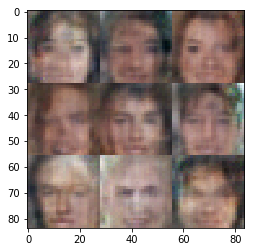

Epoch 7/10... Discriminator Loss: 0.3525... Generator Loss: 1.5680
Epoch 7/10... Discriminator Loss: 0.1393... Generator Loss: 3.3090
Epoch 7/10... Discriminator Loss: 0.0793... Generator Loss: 6.4277
Epoch 7/10... Discriminator Loss: 0.0542... Generator Loss: 4.9081
Epoch 7/10... Discriminator Loss: 0.5443... Generator Loss: 8.9444
Epoch 7/10... Discriminator Loss: 0.0936... Generator Loss: 3.9084
Epoch 7/10... Discriminator Loss: 0.6976... Generator Loss: 2.9144
Epoch 8/10... Discriminator Loss: 0.2360... Generator Loss: 2.0605
Epoch 8/10... Discriminator Loss: 0.8947... Generator Loss: 0.7486
Epoch 8/10... Discriminator Loss: 0.4066... Generator Loss: 1.6237


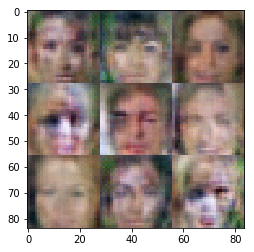

Epoch 8/10... Discriminator Loss: 0.1624... Generator Loss: 2.4141
Epoch 8/10... Discriminator Loss: 0.7148... Generator Loss: 0.9179
Epoch 8/10... Discriminator Loss: 3.9840... Generator Loss: 5.4883
Epoch 8/10... Discriminator Loss: 0.0913... Generator Loss: 4.5465
Epoch 8/10... Discriminator Loss: 0.5555... Generator Loss: 1.3520
Epoch 8/10... Discriminator Loss: 0.2035... Generator Loss: 2.2723
Epoch 8/10... Discriminator Loss: 1.2101... Generator Loss: 0.5118
Epoch 8/10... Discriminator Loss: 0.4002... Generator Loss: 2.0406
Epoch 8/10... Discriminator Loss: 0.5372... Generator Loss: 1.1939
Epoch 8/10... Discriminator Loss: 2.5363... Generator Loss: 0.1982


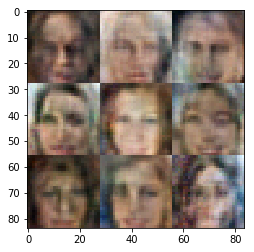

Epoch 8/10... Discriminator Loss: 0.0521... Generator Loss: 4.3843
Epoch 8/10... Discriminator Loss: 0.3313... Generator Loss: 1.8437
Epoch 8/10... Discriminator Loss: 0.1623... Generator Loss: 2.6417
Epoch 8/10... Discriminator Loss: 0.1139... Generator Loss: 3.2924
Epoch 8/10... Discriminator Loss: 0.2741... Generator Loss: 1.8103
Epoch 8/10... Discriminator Loss: 0.7162... Generator Loss: 1.0936
Epoch 8/10... Discriminator Loss: 0.0991... Generator Loss: 8.4039
Epoch 8/10... Discriminator Loss: 0.0867... Generator Loss: 2.9179
Epoch 8/10... Discriminator Loss: 0.1807... Generator Loss: 2.6972
Epoch 8/10... Discriminator Loss: 0.1269... Generator Loss: 2.8601


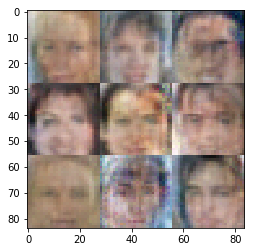

Epoch 8/10... Discriminator Loss: 0.4001... Generator Loss: 1.9007
Epoch 8/10... Discriminator Loss: 0.6260... Generator Loss: 3.2088
Epoch 8/10... Discriminator Loss: 1.1786... Generator Loss: 0.5242
Epoch 8/10... Discriminator Loss: 0.0800... Generator Loss: 6.5433
Epoch 8/10... Discriminator Loss: 0.1404... Generator Loss: 2.6106
Epoch 8/10... Discriminator Loss: 0.6488... Generator Loss: 1.1004
Epoch 8/10... Discriminator Loss: 0.2774... Generator Loss: 2.1279
Epoch 8/10... Discriminator Loss: 0.0734... Generator Loss: 5.5505
Epoch 8/10... Discriminator Loss: 0.3251... Generator Loss: 1.7072
Epoch 8/10... Discriminator Loss: 0.5232... Generator Loss: 1.3189


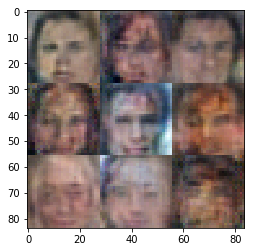

Epoch 8/10... Discriminator Loss: 0.4167... Generator Loss: 3.1559
Epoch 8/10... Discriminator Loss: 0.2587... Generator Loss: 2.7429
Epoch 8/10... Discriminator Loss: 1.7714... Generator Loss: 0.3024
Epoch 8/10... Discriminator Loss: 0.1663... Generator Loss: 2.9093
Epoch 8/10... Discriminator Loss: 0.8893... Generator Loss: 5.0403
Epoch 8/10... Discriminator Loss: 0.1603... Generator Loss: 2.7186
Epoch 8/10... Discriminator Loss: 1.2736... Generator Loss: 4.4174
Epoch 8/10... Discriminator Loss: 0.4132... Generator Loss: 6.4164
Epoch 8/10... Discriminator Loss: 0.1196... Generator Loss: 3.0990
Epoch 8/10... Discriminator Loss: 0.4603... Generator Loss: 5.6643


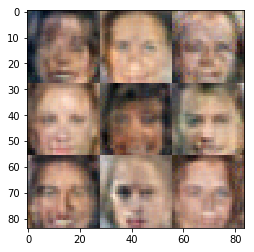

Epoch 8/10... Discriminator Loss: 2.3362... Generator Loss: 9.1800
Epoch 8/10... Discriminator Loss: 0.1346... Generator Loss: 3.2494
Epoch 8/10... Discriminator Loss: 0.6583... Generator Loss: 1.1509
Epoch 8/10... Discriminator Loss: 1.0749... Generator Loss: 0.6131
Epoch 8/10... Discriminator Loss: 0.1831... Generator Loss: 2.6751
Epoch 8/10... Discriminator Loss: 0.3239... Generator Loss: 7.6797
Epoch 8/10... Discriminator Loss: 0.3438... Generator Loss: 1.7939
Epoch 8/10... Discriminator Loss: 0.0379... Generator Loss: 5.0176
Epoch 8/10... Discriminator Loss: 0.1362... Generator Loss: 3.6381
Epoch 8/10... Discriminator Loss: 2.5296... Generator Loss: 10.0265


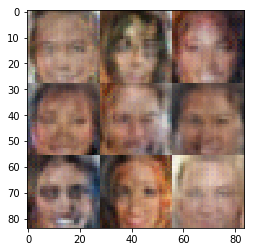

Epoch 8/10... Discriminator Loss: 0.5863... Generator Loss: 1.5117
Epoch 8/10... Discriminator Loss: 0.0558... Generator Loss: 4.7746
Epoch 8/10... Discriminator Loss: 0.7957... Generator Loss: 5.3570
Epoch 8/10... Discriminator Loss: 1.5450... Generator Loss: 0.3290
Epoch 8/10... Discriminator Loss: 0.0909... Generator Loss: 4.7396
Epoch 8/10... Discriminator Loss: 0.9259... Generator Loss: 0.7596
Epoch 8/10... Discriminator Loss: 0.0854... Generator Loss: 3.5390
Epoch 8/10... Discriminator Loss: 0.2572... Generator Loss: 5.2958
Epoch 8/10... Discriminator Loss: 2.9224... Generator Loss: 2.7148
Epoch 8/10... Discriminator Loss: 1.0557... Generator Loss: 0.6732


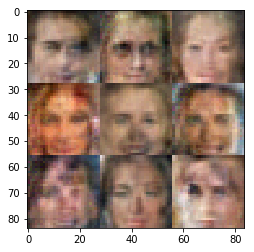

Epoch 8/10... Discriminator Loss: 0.7869... Generator Loss: 1.0028
Epoch 8/10... Discriminator Loss: 0.8926... Generator Loss: 2.3660
Epoch 8/10... Discriminator Loss: 0.6941... Generator Loss: 1.0220
Epoch 8/10... Discriminator Loss: 1.0027... Generator Loss: 1.0839
Epoch 8/10... Discriminator Loss: 0.0291... Generator Loss: 6.3272
Epoch 8/10... Discriminator Loss: 0.2717... Generator Loss: 1.9353
Epoch 8/10... Discriminator Loss: 0.2564... Generator Loss: 2.1009
Epoch 8/10... Discriminator Loss: 0.0618... Generator Loss: 3.6964
Epoch 8/10... Discriminator Loss: 0.3721... Generator Loss: 1.8002
Epoch 8/10... Discriminator Loss: 0.2412... Generator Loss: 6.2760


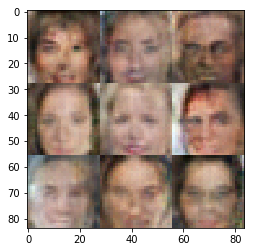

Epoch 8/10... Discriminator Loss: 0.0847... Generator Loss: 6.1113
Epoch 8/10... Discriminator Loss: 0.1638... Generator Loss: 3.7700
Epoch 8/10... Discriminator Loss: 0.5130... Generator Loss: 1.1573
Epoch 8/10... Discriminator Loss: 1.2046... Generator Loss: 8.7683
Epoch 8/10... Discriminator Loss: 0.6378... Generator Loss: 1.2951
Epoch 8/10... Discriminator Loss: 2.1697... Generator Loss: 8.3827
Epoch 8/10... Discriminator Loss: 0.1281... Generator Loss: 4.3106
Epoch 8/10... Discriminator Loss: 0.3728... Generator Loss: 4.4987
Epoch 8/10... Discriminator Loss: 0.1625... Generator Loss: 4.6338
Epoch 8/10... Discriminator Loss: 0.5502... Generator Loss: 1.5420


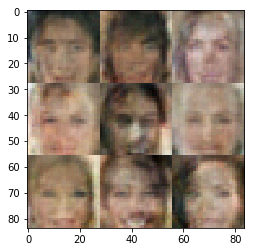

Epoch 8/10... Discriminator Loss: 1.0774... Generator Loss: 0.6779
Epoch 8/10... Discriminator Loss: 0.5766... Generator Loss: 1.2443
Epoch 8/10... Discriminator Loss: 0.1050... Generator Loss: 3.5815
Epoch 8/10... Discriminator Loss: 0.2919... Generator Loss: 2.0672
Epoch 8/10... Discriminator Loss: 0.3660... Generator Loss: 3.3214
Epoch 8/10... Discriminator Loss: 0.9315... Generator Loss: 5.5934
Epoch 8/10... Discriminator Loss: 0.0676... Generator Loss: 6.2535
Epoch 8/10... Discriminator Loss: 0.0945... Generator Loss: 3.6954
Epoch 8/10... Discriminator Loss: 0.1907... Generator Loss: 3.0290
Epoch 8/10... Discriminator Loss: 0.4258... Generator Loss: 1.5517


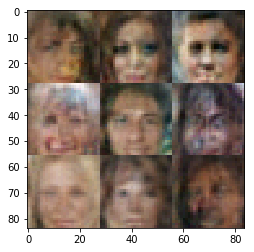

Epoch 8/10... Discriminator Loss: 0.0739... Generator Loss: 3.7570
Epoch 8/10... Discriminator Loss: 0.2214... Generator Loss: 2.4875
Epoch 8/10... Discriminator Loss: 0.0592... Generator Loss: 4.2802
Epoch 8/10... Discriminator Loss: 0.4496... Generator Loss: 1.7050
Epoch 8/10... Discriminator Loss: 0.3968... Generator Loss: 1.5961
Epoch 8/10... Discriminator Loss: 1.1355... Generator Loss: 0.6457
Epoch 8/10... Discriminator Loss: 0.1952... Generator Loss: 6.9350
Epoch 8/10... Discriminator Loss: 0.0724... Generator Loss: 3.7951
Epoch 8/10... Discriminator Loss: 1.3239... Generator Loss: 7.5836
Epoch 8/10... Discriminator Loss: 0.2222... Generator Loss: 2.2290


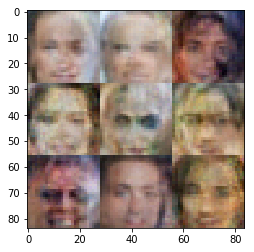

Epoch 8/10... Discriminator Loss: 0.3395... Generator Loss: 1.9222
Epoch 8/10... Discriminator Loss: 0.1840... Generator Loss: 3.0230
Epoch 8/10... Discriminator Loss: 0.0476... Generator Loss: 4.5262
Epoch 8/10... Discriminator Loss: 0.6481... Generator Loss: 1.6854
Epoch 8/10... Discriminator Loss: 0.9331... Generator Loss: 1.1437
Epoch 8/10... Discriminator Loss: 0.4328... Generator Loss: 2.6568
Epoch 8/10... Discriminator Loss: 0.9892... Generator Loss: 0.9964
Epoch 8/10... Discriminator Loss: 1.1620... Generator Loss: 0.5374
Epoch 8/10... Discriminator Loss: 0.3428... Generator Loss: 1.8382
Epoch 8/10... Discriminator Loss: 0.1424... Generator Loss: 4.4157


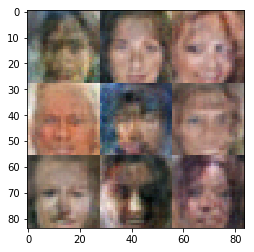

Epoch 8/10... Discriminator Loss: 0.2774... Generator Loss: 2.1673
Epoch 8/10... Discriminator Loss: 0.3587... Generator Loss: 2.6077
Epoch 8/10... Discriminator Loss: 0.7174... Generator Loss: 0.9683
Epoch 8/10... Discriminator Loss: 0.2250... Generator Loss: 2.4090
Epoch 8/10... Discriminator Loss: 0.5037... Generator Loss: 2.0768
Epoch 8/10... Discriminator Loss: 0.3694... Generator Loss: 1.5665
Epoch 8/10... Discriminator Loss: 0.0664... Generator Loss: 4.5125
Epoch 8/10... Discriminator Loss: 0.1588... Generator Loss: 4.0931
Epoch 8/10... Discriminator Loss: 0.6066... Generator Loss: 1.2625
Epoch 8/10... Discriminator Loss: 0.8554... Generator Loss: 0.8629


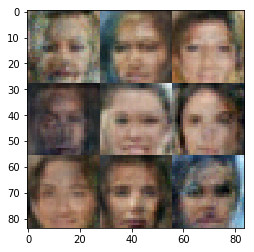

Epoch 8/10... Discriminator Loss: 0.4251... Generator Loss: 1.5148
Epoch 8/10... Discriminator Loss: 0.6851... Generator Loss: 1.2365
Epoch 8/10... Discriminator Loss: 0.1019... Generator Loss: 3.4717
Epoch 8/10... Discriminator Loss: 0.3436... Generator Loss: 4.9498
Epoch 8/10... Discriminator Loss: 0.1270... Generator Loss: 3.0771
Epoch 8/10... Discriminator Loss: 0.1961... Generator Loss: 2.4296
Epoch 8/10... Discriminator Loss: 1.2452... Generator Loss: 1.5071
Epoch 8/10... Discriminator Loss: 0.1700... Generator Loss: 3.2643
Epoch 8/10... Discriminator Loss: 1.5659... Generator Loss: 0.3349


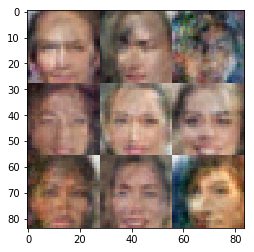

Epoch 8/10... Discriminator Loss: 0.3384... Generator Loss: 1.6073
Epoch 8/10... Discriminator Loss: 0.1548... Generator Loss: 3.5488
Epoch 8/10... Discriminator Loss: 1.1829... Generator Loss: 0.5094
Epoch 8/10... Discriminator Loss: 0.1226... Generator Loss: 4.9535
Epoch 8/10... Discriminator Loss: 0.1531... Generator Loss: 2.5221
Epoch 8/10... Discriminator Loss: 0.0433... Generator Loss: 5.6989
Epoch 8/10... Discriminator Loss: 0.0361... Generator Loss: 5.4700
Epoch 8/10... Discriminator Loss: 1.4635... Generator Loss: 1.8111
Epoch 8/10... Discriminator Loss: 0.3156... Generator Loss: 4.1880
Epoch 8/10... Discriminator Loss: 0.3387... Generator Loss: 1.6433


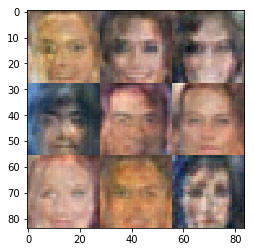

Epoch 8/10... Discriminator Loss: 1.6813... Generator Loss: 5.1392
Epoch 8/10... Discriminator Loss: 0.3644... Generator Loss: 3.2501
Epoch 8/10... Discriminator Loss: 0.1147... Generator Loss: 3.3653
Epoch 8/10... Discriminator Loss: 0.1444... Generator Loss: 4.7772
Epoch 8/10... Discriminator Loss: 0.1654... Generator Loss: 2.9709
Epoch 8/10... Discriminator Loss: 0.9991... Generator Loss: 0.6808
Epoch 8/10... Discriminator Loss: 0.1311... Generator Loss: 3.0585
Epoch 8/10... Discriminator Loss: 0.1155... Generator Loss: 5.0501
Epoch 8/10... Discriminator Loss: 0.0706... Generator Loss: 4.0017
Epoch 8/10... Discriminator Loss: 0.1837... Generator Loss: 4.4133


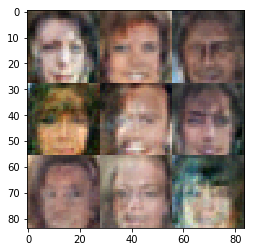

Epoch 8/10... Discriminator Loss: 0.4828... Generator Loss: 1.3615
Epoch 8/10... Discriminator Loss: 0.0378... Generator Loss: 6.4924
Epoch 8/10... Discriminator Loss: 0.1034... Generator Loss: 3.1960
Epoch 8/10... Discriminator Loss: 1.4920... Generator Loss: 0.4477
Epoch 8/10... Discriminator Loss: 0.8630... Generator Loss: 1.0021
Epoch 9/10... Discriminator Loss: 0.5301... Generator Loss: 1.5012
Epoch 9/10... Discriminator Loss: 0.1690... Generator Loss: 2.6418
Epoch 9/10... Discriminator Loss: 0.8724... Generator Loss: 0.9224
Epoch 9/10... Discriminator Loss: 1.3280... Generator Loss: 0.4714
Epoch 9/10... Discriminator Loss: 1.4579... Generator Loss: 9.0369


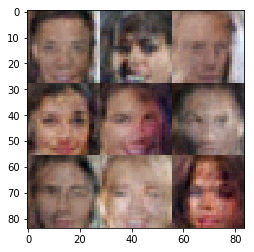

Epoch 9/10... Discriminator Loss: 1.0695... Generator Loss: 2.8129
Epoch 9/10... Discriminator Loss: 0.3520... Generator Loss: 1.8436
Epoch 9/10... Discriminator Loss: 3.0120... Generator Loss: 0.0748
Epoch 9/10... Discriminator Loss: 0.4369... Generator Loss: 1.6359
Epoch 9/10... Discriminator Loss: 1.1746... Generator Loss: 0.5340
Epoch 9/10... Discriminator Loss: 0.5722... Generator Loss: 1.2831
Epoch 9/10... Discriminator Loss: 0.2592... Generator Loss: 2.0507
Epoch 9/10... Discriminator Loss: 0.2765... Generator Loss: 1.8270
Epoch 9/10... Discriminator Loss: 0.1155... Generator Loss: 3.8557
Epoch 9/10... Discriminator Loss: 0.1962... Generator Loss: 2.3988


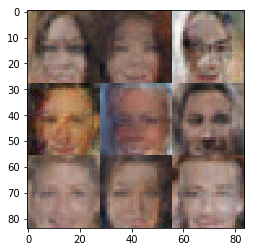

Epoch 9/10... Discriminator Loss: 0.3498... Generator Loss: 4.1146
Epoch 9/10... Discriminator Loss: 0.0849... Generator Loss: 4.7152
Epoch 9/10... Discriminator Loss: 0.2043... Generator Loss: 2.1852
Epoch 9/10... Discriminator Loss: 0.3567... Generator Loss: 6.0929
Epoch 9/10... Discriminator Loss: 0.4720... Generator Loss: 1.3904
Epoch 9/10... Discriminator Loss: 1.1710... Generator Loss: 0.5725
Epoch 9/10... Discriminator Loss: 1.8369... Generator Loss: 0.2565
Epoch 9/10... Discriminator Loss: 1.1618... Generator Loss: 0.5624
Epoch 9/10... Discriminator Loss: 0.8470... Generator Loss: 2.4559
Epoch 9/10... Discriminator Loss: 0.1047... Generator Loss: 4.2717


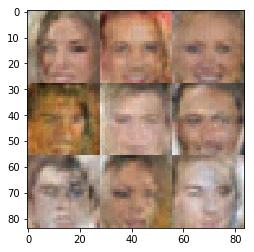

Epoch 9/10... Discriminator Loss: 0.3270... Generator Loss: 4.1509
Epoch 9/10... Discriminator Loss: 0.8381... Generator Loss: 6.4844
Epoch 9/10... Discriminator Loss: 0.2363... Generator Loss: 2.4215
Epoch 9/10... Discriminator Loss: 1.1154... Generator Loss: 0.5884
Epoch 9/10... Discriminator Loss: 1.0263... Generator Loss: 0.6335
Epoch 9/10... Discriminator Loss: 1.0953... Generator Loss: 0.6134
Epoch 9/10... Discriminator Loss: 0.1767... Generator Loss: 5.2559
Epoch 9/10... Discriminator Loss: 0.1816... Generator Loss: 3.4489
Epoch 9/10... Discriminator Loss: 0.2756... Generator Loss: 8.0178
Epoch 9/10... Discriminator Loss: 0.7189... Generator Loss: 0.9570


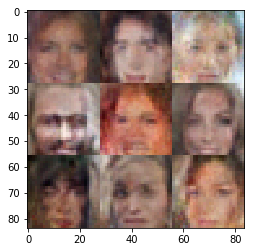

Epoch 9/10... Discriminator Loss: 1.6336... Generator Loss: 4.8593
Epoch 9/10... Discriminator Loss: 0.6136... Generator Loss: 1.0540
Epoch 9/10... Discriminator Loss: 0.1355... Generator Loss: 3.4724
Epoch 9/10... Discriminator Loss: 0.7325... Generator Loss: 1.0000
Epoch 9/10... Discriminator Loss: 0.1994... Generator Loss: 3.2768
Epoch 9/10... Discriminator Loss: 0.1526... Generator Loss: 2.9110
Epoch 9/10... Discriminator Loss: 0.9560... Generator Loss: 0.6543
Epoch 9/10... Discriminator Loss: 1.2122... Generator Loss: 0.5847
Epoch 9/10... Discriminator Loss: 0.3897... Generator Loss: 1.6015
Epoch 9/10... Discriminator Loss: 0.5893... Generator Loss: 4.7778


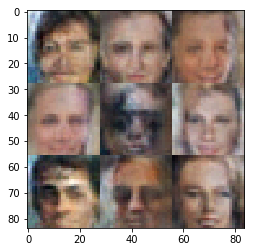

Epoch 9/10... Discriminator Loss: 0.1588... Generator Loss: 2.6965
Epoch 9/10... Discriminator Loss: 0.3972... Generator Loss: 1.8358
Epoch 9/10... Discriminator Loss: 1.1842... Generator Loss: 0.5831
Epoch 9/10... Discriminator Loss: 0.5090... Generator Loss: 6.8860
Epoch 9/10... Discriminator Loss: 0.2434... Generator Loss: 2.3060
Epoch 9/10... Discriminator Loss: 0.6512... Generator Loss: 0.9986
Epoch 9/10... Discriminator Loss: 0.6080... Generator Loss: 1.2273
Epoch 9/10... Discriminator Loss: 0.1953... Generator Loss: 2.6394
Epoch 9/10... Discriminator Loss: 0.8194... Generator Loss: 2.9630
Epoch 9/10... Discriminator Loss: 0.2770... Generator Loss: 2.1956


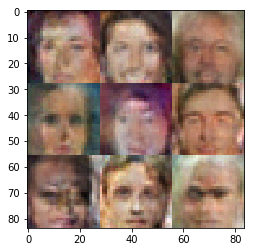

Epoch 9/10... Discriminator Loss: 2.0051... Generator Loss: 4.4780
Epoch 9/10... Discriminator Loss: 0.3986... Generator Loss: 2.2661
Epoch 9/10... Discriminator Loss: 0.3515... Generator Loss: 1.6792
Epoch 9/10... Discriminator Loss: 0.2017... Generator Loss: 2.8585
Epoch 9/10... Discriminator Loss: 1.1235... Generator Loss: 0.6153
Epoch 9/10... Discriminator Loss: 1.4661... Generator Loss: 0.4823
Epoch 9/10... Discriminator Loss: 0.4372... Generator Loss: 1.3854
Epoch 9/10... Discriminator Loss: 1.0297... Generator Loss: 1.8558
Epoch 9/10... Discriminator Loss: 0.2308... Generator Loss: 3.6656
Epoch 9/10... Discriminator Loss: 1.2279... Generator Loss: 4.2347


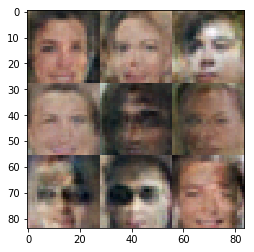

Epoch 9/10... Discriminator Loss: 1.0728... Generator Loss: 0.6128
Epoch 9/10... Discriminator Loss: 0.7289... Generator Loss: 0.9905
Epoch 9/10... Discriminator Loss: 0.5607... Generator Loss: 1.3065
Epoch 9/10... Discriminator Loss: 1.1096... Generator Loss: 0.5980
Epoch 9/10... Discriminator Loss: 0.4886... Generator Loss: 1.5913
Epoch 9/10... Discriminator Loss: 0.5083... Generator Loss: 1.3406
Epoch 9/10... Discriminator Loss: 0.1640... Generator Loss: 2.5521
Epoch 9/10... Discriminator Loss: 0.1669... Generator Loss: 3.2954
Epoch 9/10... Discriminator Loss: 0.1553... Generator Loss: 2.6199
Epoch 9/10... Discriminator Loss: 0.8767... Generator Loss: 0.7292


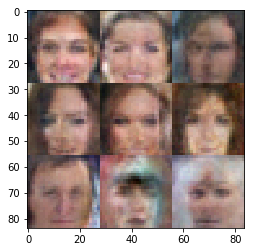

Epoch 9/10... Discriminator Loss: 0.6305... Generator Loss: 1.3408
Epoch 9/10... Discriminator Loss: 0.4444... Generator Loss: 2.5989
Epoch 9/10... Discriminator Loss: 0.6556... Generator Loss: 1.1695
Epoch 9/10... Discriminator Loss: 0.4938... Generator Loss: 1.7032
Epoch 9/10... Discriminator Loss: 0.5338... Generator Loss: 1.3392
Epoch 9/10... Discriminator Loss: 0.2285... Generator Loss: 2.7349
Epoch 9/10... Discriminator Loss: 0.2421... Generator Loss: 2.4284
Epoch 9/10... Discriminator Loss: 0.1395... Generator Loss: 2.8285
Epoch 9/10... Discriminator Loss: 1.2640... Generator Loss: 3.5280
Epoch 9/10... Discriminator Loss: 0.4823... Generator Loss: 2.0319


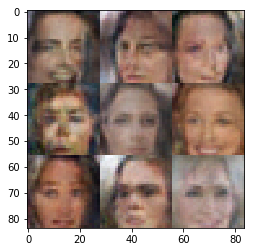

Epoch 9/10... Discriminator Loss: 0.4823... Generator Loss: 1.7798
Epoch 9/10... Discriminator Loss: 0.2273... Generator Loss: 2.7509
Epoch 9/10... Discriminator Loss: 0.8147... Generator Loss: 3.4277
Epoch 9/10... Discriminator Loss: 0.4071... Generator Loss: 3.6776
Epoch 9/10... Discriminator Loss: 0.2596... Generator Loss: 5.4275
Epoch 9/10... Discriminator Loss: 0.3598... Generator Loss: 3.0973
Epoch 9/10... Discriminator Loss: 0.3580... Generator Loss: 1.6661
Epoch 9/10... Discriminator Loss: 0.2699... Generator Loss: 4.2325
Epoch 9/10... Discriminator Loss: 0.1993... Generator Loss: 2.3667
Epoch 9/10... Discriminator Loss: 0.0694... Generator Loss: 6.4067


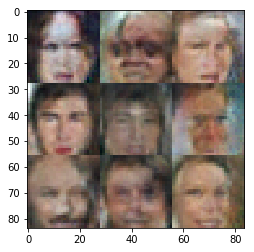

Epoch 9/10... Discriminator Loss: 1.4312... Generator Loss: 2.9620
Epoch 9/10... Discriminator Loss: 0.6922... Generator Loss: 2.6508
Epoch 9/10... Discriminator Loss: 0.8859... Generator Loss: 0.9631
Epoch 9/10... Discriminator Loss: 0.7603... Generator Loss: 0.9202
Epoch 9/10... Discriminator Loss: 0.3521... Generator Loss: 3.8862
Epoch 9/10... Discriminator Loss: 1.2269... Generator Loss: 0.5833
Epoch 9/10... Discriminator Loss: 0.5110... Generator Loss: 2.5590
Epoch 9/10... Discriminator Loss: 0.6736... Generator Loss: 3.3403
Epoch 9/10... Discriminator Loss: 0.8720... Generator Loss: 0.7692
Epoch 9/10... Discriminator Loss: 0.4553... Generator Loss: 2.3136


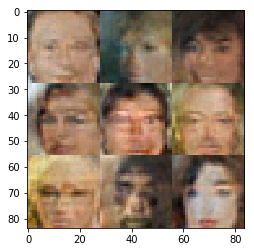

Epoch 9/10... Discriminator Loss: 0.1654... Generator Loss: 3.2416
Epoch 9/10... Discriminator Loss: 0.3567... Generator Loss: 1.6650
Epoch 9/10... Discriminator Loss: 0.2730... Generator Loss: 2.3361
Epoch 9/10... Discriminator Loss: 1.1489... Generator Loss: 3.7945
Epoch 9/10... Discriminator Loss: 0.4883... Generator Loss: 1.7052
Epoch 9/10... Discriminator Loss: 0.6690... Generator Loss: 1.1314
Epoch 9/10... Discriminator Loss: 0.5516... Generator Loss: 1.9554
Epoch 9/10... Discriminator Loss: 2.7151... Generator Loss: 0.1483
Epoch 9/10... Discriminator Loss: 0.7559... Generator Loss: 1.1839
Epoch 9/10... Discriminator Loss: 0.3833... Generator Loss: 1.6011


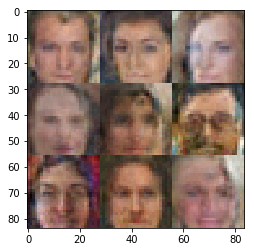

Epoch 9/10... Discriminator Loss: 0.3315... Generator Loss: 2.3317
Epoch 9/10... Discriminator Loss: 0.6310... Generator Loss: 1.1645
Epoch 9/10... Discriminator Loss: 0.4821... Generator Loss: 2.8605
Epoch 9/10... Discriminator Loss: 0.2150... Generator Loss: 2.4204
Epoch 9/10... Discriminator Loss: 0.1070... Generator Loss: 3.0961
Epoch 9/10... Discriminator Loss: 1.6500... Generator Loss: 7.2562
Epoch 9/10... Discriminator Loss: 0.4553... Generator Loss: 1.6145
Epoch 9/10... Discriminator Loss: 0.5126... Generator Loss: 2.5972
Epoch 9/10... Discriminator Loss: 1.4860... Generator Loss: 0.4283
Epoch 9/10... Discriminator Loss: 0.5324... Generator Loss: 1.4649


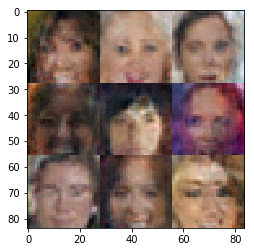

Epoch 9/10... Discriminator Loss: 0.5626... Generator Loss: 1.2829
Epoch 9/10... Discriminator Loss: 0.1877... Generator Loss: 2.5942
Epoch 9/10... Discriminator Loss: 0.2247... Generator Loss: 2.6491
Epoch 9/10... Discriminator Loss: 1.0319... Generator Loss: 0.6548
Epoch 9/10... Discriminator Loss: 0.4744... Generator Loss: 3.2181
Epoch 9/10... Discriminator Loss: 0.2841... Generator Loss: 1.9360
Epoch 9/10... Discriminator Loss: 0.6421... Generator Loss: 1.0084
Epoch 9/10... Discriminator Loss: 0.8432... Generator Loss: 0.8340
Epoch 9/10... Discriminator Loss: 1.0157... Generator Loss: 4.8988
Epoch 9/10... Discriminator Loss: 0.5478... Generator Loss: 1.4596


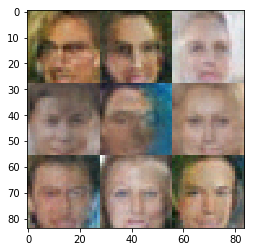

Epoch 9/10... Discriminator Loss: 0.6559... Generator Loss: 3.0747
Epoch 9/10... Discriminator Loss: 0.4644... Generator Loss: 1.6849
Epoch 9/10... Discriminator Loss: 0.0877... Generator Loss: 3.9803
Epoch 9/10... Discriminator Loss: 0.1351... Generator Loss: 3.0101
Epoch 9/10... Discriminator Loss: 0.2586... Generator Loss: 2.2412
Epoch 9/10... Discriminator Loss: 0.3008... Generator Loss: 1.7817
Epoch 9/10... Discriminator Loss: 0.6647... Generator Loss: 1.0851
Epoch 9/10... Discriminator Loss: 0.5332... Generator Loss: 1.2416
Epoch 9/10... Discriminator Loss: 0.5250... Generator Loss: 1.3633
Epoch 9/10... Discriminator Loss: 0.2206... Generator Loss: 2.2908


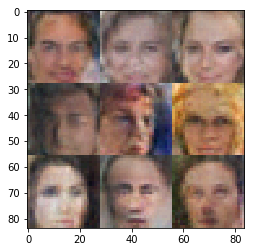

Epoch 9/10... Discriminator Loss: 0.2765... Generator Loss: 2.1242
Epoch 9/10... Discriminator Loss: 0.6734... Generator Loss: 1.0101
Epoch 9/10... Discriminator Loss: 0.5875... Generator Loss: 1.2984
Epoch 9/10... Discriminator Loss: 0.8426... Generator Loss: 0.9789
Epoch 9/10... Discriminator Loss: 0.3735... Generator Loss: 1.9372
Epoch 9/10... Discriminator Loss: 1.1524... Generator Loss: 0.6381
Epoch 9/10... Discriminator Loss: 1.2541... Generator Loss: 0.5513
Epoch 9/10... Discriminator Loss: 1.8248... Generator Loss: 0.4072
Epoch 9/10... Discriminator Loss: 0.5295... Generator Loss: 1.4418
Epoch 9/10... Discriminator Loss: 0.7362... Generator Loss: 1.0962


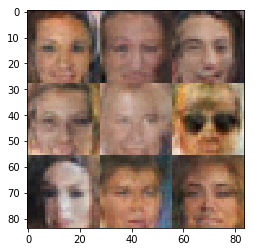

Epoch 9/10... Discriminator Loss: 1.3879... Generator Loss: 0.4505
Epoch 9/10... Discriminator Loss: 0.3254... Generator Loss: 2.4264
Epoch 9/10... Discriminator Loss: 0.3000... Generator Loss: 2.0738
Epoch 10/10... Discriminator Loss: 0.4346... Generator Loss: 2.6221
Epoch 10/10... Discriminator Loss: 0.5443... Generator Loss: 1.3645
Epoch 10/10... Discriminator Loss: 0.6537... Generator Loss: 1.1342
Epoch 10/10... Discriminator Loss: 0.1400... Generator Loss: 3.1062
Epoch 10/10... Discriminator Loss: 0.2911... Generator Loss: 1.9734
Epoch 10/10... Discriminator Loss: 0.3847... Generator Loss: 3.8918
Epoch 10/10... Discriminator Loss: 0.5589... Generator Loss: 1.2640


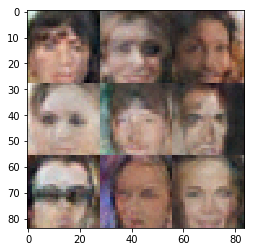

Epoch 10/10... Discriminator Loss: 0.3307... Generator Loss: 1.8441
Epoch 10/10... Discriminator Loss: 0.3487... Generator Loss: 2.1745
Epoch 10/10... Discriminator Loss: 1.5613... Generator Loss: 0.4099
Epoch 10/10... Discriminator Loss: 0.4954... Generator Loss: 2.6743
Epoch 10/10... Discriminator Loss: 0.3939... Generator Loss: 1.9392
Epoch 10/10... Discriminator Loss: 0.5727... Generator Loss: 1.1389
Epoch 10/10... Discriminator Loss: 0.6913... Generator Loss: 1.1156
Epoch 10/10... Discriminator Loss: 0.4373... Generator Loss: 1.4743
Epoch 10/10... Discriminator Loss: 0.0794... Generator Loss: 4.8516
Epoch 10/10... Discriminator Loss: 0.5939... Generator Loss: 1.0755


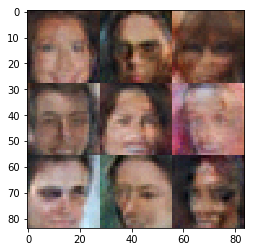

Epoch 10/10... Discriminator Loss: 0.1045... Generator Loss: 3.6846
Epoch 10/10... Discriminator Loss: 1.3163... Generator Loss: 4.9309
Epoch 10/10... Discriminator Loss: 2.2650... Generator Loss: 2.7906
Epoch 10/10... Discriminator Loss: 0.8757... Generator Loss: 0.8605
Epoch 10/10... Discriminator Loss: 0.6555... Generator Loss: 1.1382
Epoch 10/10... Discriminator Loss: 0.3062... Generator Loss: 2.3534
Epoch 10/10... Discriminator Loss: 0.4666... Generator Loss: 1.8911
Epoch 10/10... Discriminator Loss: 0.1622... Generator Loss: 2.6376
Epoch 10/10... Discriminator Loss: 0.3285... Generator Loss: 1.6727
Epoch 10/10... Discriminator Loss: 1.6807... Generator Loss: 5.0166


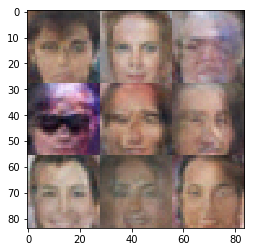

Epoch 10/10... Discriminator Loss: 0.6297... Generator Loss: 1.2158
Epoch 10/10... Discriminator Loss: 0.3611... Generator Loss: 2.1199
Epoch 10/10... Discriminator Loss: 0.1997... Generator Loss: 2.9581
Epoch 10/10... Discriminator Loss: 1.0033... Generator Loss: 0.6683
Epoch 10/10... Discriminator Loss: 0.3781... Generator Loss: 2.5622
Epoch 10/10... Discriminator Loss: 0.3501... Generator Loss: 1.9140
Epoch 10/10... Discriminator Loss: 0.3449... Generator Loss: 1.7568
Epoch 10/10... Discriminator Loss: 1.0488... Generator Loss: 0.6809
Epoch 10/10... Discriminator Loss: 0.2781... Generator Loss: 2.6032
Epoch 10/10... Discriminator Loss: 0.8922... Generator Loss: 4.8155


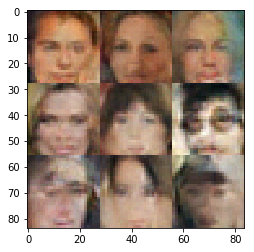

Epoch 10/10... Discriminator Loss: 0.2044... Generator Loss: 2.2906
Epoch 10/10... Discriminator Loss: 0.5562... Generator Loss: 5.1326
Epoch 10/10... Discriminator Loss: 0.1589... Generator Loss: 3.3987
Epoch 10/10... Discriminator Loss: 0.6984... Generator Loss: 0.8916
Epoch 10/10... Discriminator Loss: 0.9449... Generator Loss: 4.0572
Epoch 10/10... Discriminator Loss: 0.8229... Generator Loss: 1.7670
Epoch 10/10... Discriminator Loss: 1.0580... Generator Loss: 0.7877
Epoch 10/10... Discriminator Loss: 0.2553... Generator Loss: 2.9376
Epoch 10/10... Discriminator Loss: 0.5190... Generator Loss: 1.3562
Epoch 10/10... Discriminator Loss: 0.9391... Generator Loss: 0.7229


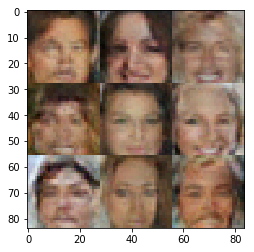

Epoch 10/10... Discriminator Loss: 0.4877... Generator Loss: 1.2467
Epoch 10/10... Discriminator Loss: 0.1578... Generator Loss: 2.4806
Epoch 10/10... Discriminator Loss: 0.1671... Generator Loss: 2.4906
Epoch 10/10... Discriminator Loss: 0.0729... Generator Loss: 5.0803
Epoch 10/10... Discriminator Loss: 0.1094... Generator Loss: 3.0133
Epoch 10/10... Discriminator Loss: 2.0604... Generator Loss: 0.3503
Epoch 10/10... Discriminator Loss: 0.5729... Generator Loss: 1.7976
Epoch 10/10... Discriminator Loss: 0.4147... Generator Loss: 1.6675
Epoch 10/10... Discriminator Loss: 0.5185... Generator Loss: 1.8760
Epoch 10/10... Discriminator Loss: 0.6612... Generator Loss: 1.2059


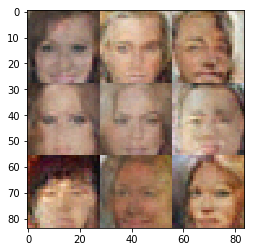

Epoch 10/10... Discriminator Loss: 0.5719... Generator Loss: 1.4216
Epoch 10/10... Discriminator Loss: 1.0860... Generator Loss: 0.5597
Epoch 10/10... Discriminator Loss: 0.4830... Generator Loss: 1.9986
Epoch 10/10... Discriminator Loss: 0.4493... Generator Loss: 2.0403
Epoch 10/10... Discriminator Loss: 0.4784... Generator Loss: 1.5438
Epoch 10/10... Discriminator Loss: 0.9204... Generator Loss: 0.7018
Epoch 10/10... Discriminator Loss: 0.3980... Generator Loss: 1.5415
Epoch 10/10... Discriminator Loss: 0.2941... Generator Loss: 2.5211
Epoch 10/10... Discriminator Loss: 1.1089... Generator Loss: 0.5835
Epoch 10/10... Discriminator Loss: 0.1965... Generator Loss: 2.6053


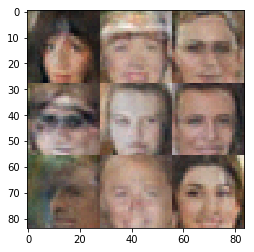

Epoch 10/10... Discriminator Loss: 1.4536... Generator Loss: 0.5022
Epoch 10/10... Discriminator Loss: 2.1969... Generator Loss: 5.2620
Epoch 10/10... Discriminator Loss: 1.9277... Generator Loss: 0.3191
Epoch 10/10... Discriminator Loss: 0.3589... Generator Loss: 2.4056
Epoch 10/10... Discriminator Loss: 0.1584... Generator Loss: 3.3371
Epoch 10/10... Discriminator Loss: 0.3343... Generator Loss: 1.8117
Epoch 10/10... Discriminator Loss: 0.3018... Generator Loss: 2.2967
Epoch 10/10... Discriminator Loss: 1.3323... Generator Loss: 0.4722
Epoch 10/10... Discriminator Loss: 0.6103... Generator Loss: 1.3076
Epoch 10/10... Discriminator Loss: 0.7757... Generator Loss: 0.9459


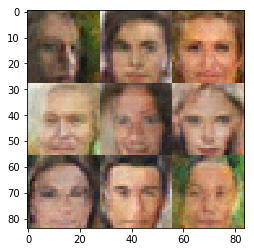

Epoch 10/10... Discriminator Loss: 0.2895... Generator Loss: 2.3954
Epoch 10/10... Discriminator Loss: 0.6856... Generator Loss: 1.0202
Epoch 10/10... Discriminator Loss: 0.6384... Generator Loss: 1.0125
Epoch 10/10... Discriminator Loss: 0.6624... Generator Loss: 1.1072
Epoch 10/10... Discriminator Loss: 0.1297... Generator Loss: 2.9839
Epoch 10/10... Discriminator Loss: 1.1773... Generator Loss: 0.5618
Epoch 10/10... Discriminator Loss: 0.2600... Generator Loss: 2.2642
Epoch 10/10... Discriminator Loss: 1.3488... Generator Loss: 0.4767
Epoch 10/10... Discriminator Loss: 1.0913... Generator Loss: 0.5796
Epoch 10/10... Discriminator Loss: 0.1363... Generator Loss: 4.5911


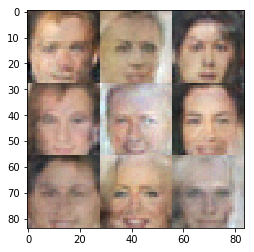

Epoch 10/10... Discriminator Loss: 0.3270... Generator Loss: 1.7458
Epoch 10/10... Discriminator Loss: 0.3850... Generator Loss: 2.2199
Epoch 10/10... Discriminator Loss: 0.3889... Generator Loss: 1.7596
Epoch 10/10... Discriminator Loss: 0.1006... Generator Loss: 3.9279
Epoch 10/10... Discriminator Loss: 0.1044... Generator Loss: 3.3339
Epoch 10/10... Discriminator Loss: 0.5128... Generator Loss: 1.3505
Epoch 10/10... Discriminator Loss: 0.7570... Generator Loss: 0.8450
Epoch 10/10... Discriminator Loss: 0.2732... Generator Loss: 2.1408
Epoch 10/10... Discriminator Loss: 0.9864... Generator Loss: 1.6604
Epoch 10/10... Discriminator Loss: 0.4119... Generator Loss: 2.0769


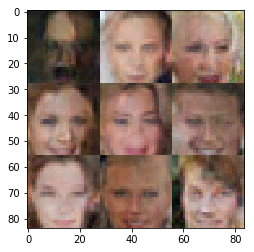

Epoch 10/10... Discriminator Loss: 1.1500... Generator Loss: 0.5692
Epoch 10/10... Discriminator Loss: 0.5076... Generator Loss: 3.9286
Epoch 10/10... Discriminator Loss: 0.5464... Generator Loss: 1.3483
Epoch 10/10... Discriminator Loss: 1.6497... Generator Loss: 0.3290
Epoch 10/10... Discriminator Loss: 0.7144... Generator Loss: 0.9505
Epoch 10/10... Discriminator Loss: 0.2816... Generator Loss: 1.9824
Epoch 10/10... Discriminator Loss: 0.1778... Generator Loss: 2.6072
Epoch 10/10... Discriminator Loss: 0.2809... Generator Loss: 2.6129
Epoch 10/10... Discriminator Loss: 0.6689... Generator Loss: 1.1487
Epoch 10/10... Discriminator Loss: 0.3585... Generator Loss: 1.7980


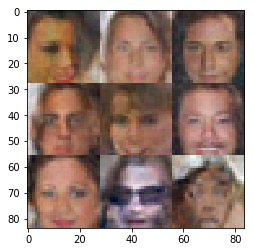

Epoch 10/10... Discriminator Loss: 0.1903... Generator Loss: 2.2969
Epoch 10/10... Discriminator Loss: 0.8365... Generator Loss: 0.8020
Epoch 10/10... Discriminator Loss: 0.5576... Generator Loss: 1.1515
Epoch 10/10... Discriminator Loss: 1.2696... Generator Loss: 0.6512
Epoch 10/10... Discriminator Loss: 0.5063... Generator Loss: 1.4351
Epoch 10/10... Discriminator Loss: 1.9446... Generator Loss: 0.2441
Epoch 10/10... Discriminator Loss: 0.3049... Generator Loss: 1.9001
Epoch 10/10... Discriminator Loss: 0.3840... Generator Loss: 3.5573
Epoch 10/10... Discriminator Loss: 0.3229... Generator Loss: 2.1785
Epoch 10/10... Discriminator Loss: 0.9128... Generator Loss: 4.2506


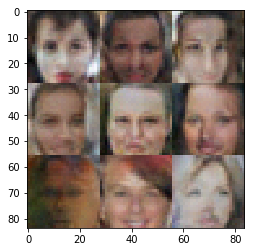

Epoch 10/10... Discriminator Loss: 1.6758... Generator Loss: 4.6650
Epoch 10/10... Discriminator Loss: 0.7639... Generator Loss: 0.9902
Epoch 10/10... Discriminator Loss: 0.3973... Generator Loss: 1.5982
Epoch 10/10... Discriminator Loss: 0.1290... Generator Loss: 3.4910
Epoch 10/10... Discriminator Loss: 0.1079... Generator Loss: 3.1911
Epoch 10/10... Discriminator Loss: 0.5959... Generator Loss: 1.1136
Epoch 10/10... Discriminator Loss: 0.7915... Generator Loss: 0.8748
Epoch 10/10... Discriminator Loss: 1.0697... Generator Loss: 0.6992
Epoch 10/10... Discriminator Loss: 0.8877... Generator Loss: 0.8284
Epoch 10/10... Discriminator Loss: 0.0876... Generator Loss: 4.2884


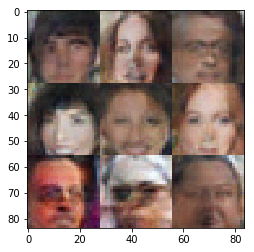

Epoch 10/10... Discriminator Loss: 0.3484... Generator Loss: 1.6644
Epoch 10/10... Discriminator Loss: 0.2571... Generator Loss: 2.3861
Epoch 10/10... Discriminator Loss: 0.1124... Generator Loss: 2.9919
Epoch 10/10... Discriminator Loss: 1.4254... Generator Loss: 0.4444
Epoch 10/10... Discriminator Loss: 0.6036... Generator Loss: 1.9907
Epoch 10/10... Discriminator Loss: 0.5496... Generator Loss: 1.2703
Epoch 10/10... Discriminator Loss: 0.4888... Generator Loss: 2.5062
Epoch 10/10... Discriminator Loss: 0.2366... Generator Loss: 3.4563
Epoch 10/10... Discriminator Loss: 0.9192... Generator Loss: 0.7798
Epoch 10/10... Discriminator Loss: 0.3242... Generator Loss: 1.8504


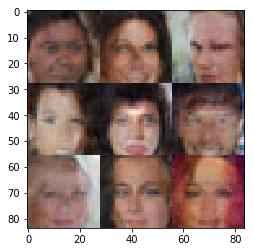

Epoch 10/10... Discriminator Loss: 1.1974... Generator Loss: 0.5325
Epoch 10/10... Discriminator Loss: 0.4524... Generator Loss: 1.8302
Epoch 10/10... Discriminator Loss: 0.1357... Generator Loss: 3.9040
Epoch 10/10... Discriminator Loss: 0.0983... Generator Loss: 3.3660
Epoch 10/10... Discriminator Loss: 0.2341... Generator Loss: 2.0895
Epoch 10/10... Discriminator Loss: 0.2316... Generator Loss: 2.0600
Epoch 10/10... Discriminator Loss: 0.3238... Generator Loss: 1.6955
Epoch 10/10... Discriminator Loss: 0.1239... Generator Loss: 6.7777
Epoch 10/10... Discriminator Loss: 2.3385... Generator Loss: 0.6047
Epoch 10/10... Discriminator Loss: 0.5798... Generator Loss: 1.5287


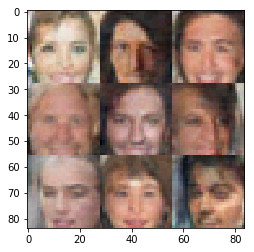

Epoch 10/10... Discriminator Loss: 0.6017... Generator Loss: 2.5321
Epoch 10/10... Discriminator Loss: 0.6313... Generator Loss: 1.1844
Epoch 10/10... Discriminator Loss: 0.7258... Generator Loss: 3.5646
Epoch 10/10... Discriminator Loss: 0.3000... Generator Loss: 3.7159
Epoch 10/10... Discriminator Loss: 0.2941... Generator Loss: 1.7706
Epoch 10/10... Discriminator Loss: 0.3713... Generator Loss: 1.7142
Epoch 10/10... Discriminator Loss: 1.1159... Generator Loss: 0.6056
Epoch 10/10... Discriminator Loss: 0.0834... Generator Loss: 3.6204
Epoch 10/10... Discriminator Loss: 0.2444... Generator Loss: 2.1405
Epoch 10/10... Discriminator Loss: 0.1342... Generator Loss: 5.7276


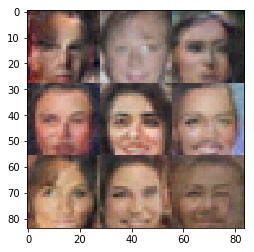

Epoch 10/10... Discriminator Loss: 0.6638... Generator Loss: 2.5664
Epoch 10/10... Discriminator Loss: 0.8292... Generator Loss: 0.9383


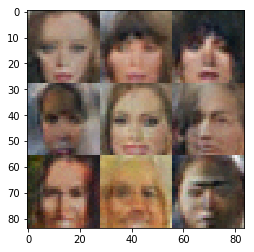

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.